In [2]:
import os,sys,time
import numpy as np
from scipy.io import wavfile
import sklearn

from IPython.display import Audio

import musiclib, database

%load_ext cython

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import figure
import numpy as np
            
def plotColorMap(x, y, figsize):
    print("white means no mistake")
    print("red means playing when not supposed to")
    print("orange means not playing when supposed to")
    print("black means playing when supposed to")
    cmap = colors.ListedColormap(['white','red','orange','black'])
    bounds = [0,1,2,3,4]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(x[::512]), interpolation='none', cmap='Greys', aspect=4)
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(y[::512]), interpolation='none', cmap='Greys', aspect=4)
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(x[::512])*2 + np.transpose(y[::512]), interpolation='none', cmap=cmap, aspect=4, norm=norm)

In [4]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef align(float[:,:] sig1,float[:,:] sig2):
    cdef int d = sig1.shape[1]
    cdef int len1 = sig1.shape[0]
    cdef int len2 = sig2.shape[0]
    cdef np.ndarray[np.float32_t, ndim=2] npL = np.empty((len1,len2), dtype=np.float32)
    cdef np.ndarray[np.float32_t, ndim=2] npP = np.empty((len1,len2), dtype=np.float32)
    
    cdef float[:,:] L = npL
    cdef float[:,:] P = npP
    
    cdef float cost,tmp
    cdef int j,k,i
    for j in range(0,len1):
        for k in range(0,len2):
            cost = 0
            for i in range(d):
                tmp = sig1[j,i] - sig2[k,i]
                cost += tmp * tmp
            cost = sqrt(cost)
            
            if j == 0 and k == 0:
                L[j,k] = cost
                P[j,k] = 3
            elif k == 0:
                L[j,k] = cost + L[j-1,k]
                P[j,k] = 2
            elif j == 0:
                L[j,k] = cost + L[j,k-1]
                P[j,k] = 1
            else: # j, k > 0
                if L[j-1,k] < L[j,k-1] and L[j-1,k] < L[j-1,k-1]: # insertion (up)
                    P[j,k] = 1
                    L[j,k] = cost + L[j-1,k]
                elif L[j,k-1] < L[j-1,k-1]: # deletion (left)
                    P[j,k] = 2
                    L[j,k] = cost + L[j,k-1]
                else: # match (up left)
                    P[j,k] = 3
                    L[j,k] = cost + L[j-1,k-1]
    
    return npL,npP

In [5]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

def traceback_loss(float[:,:] sig1,float[:,:] sig2, float[:,:] L):
    sig12 = np.zeros(sig2.shape) # align 1 onto 2
    cdef int j = sig1.shape[0]-1
    cdef int k = sig2.shape[0]-1
    A = []
    C = []
    cdef float cost,tmp
    while True:
        if j == 0 and k == 0:
            A.append((0,0))
            C.append(L[0,0])
            break # got back to the beginning
        
        cost = 0
        for i in range(sig1.shape[1]):
            tmp = sig1[j,i] - sig2[k,i]
            cost += tmp * tmp
        cost = sqrt(cost)
        
        if j>0 and k>0 and L[j,k] == L[j-1,k-1] + cost: # progress
            A.append((j,k))
            C.append(L[j,k])
            j -= 1
            k -= 1
        elif k>0 and L[j,k] == L[j,k-1] + cost: # stay sig2
            A.append((j,k))
            C.append(L[j,k])
            k -= 1
        elif j>0 and L[j,k] == L[j-1,k] + cost: # stay sig1
            A.append((j,k))
            C.append(L[j,k])
            j -= 1
        else: 
#             print 'j',j
#             print 'k',k
#             print 'cost',cost
#             print 'L[j,k]',L[j,k]
#             print 'L[j,k]-cost',L[j,k]-cost
#             print 'L[j,k-1]',L[j,k-1]
#             print 'L[j-1,k]',L[j-1,k]
#             print 'L[j-1,k-1]',L[j-1,k-1]
            assert False
    
    return list(reversed(A)),list(reversed(C))

# Performance 61 aligns properly

record ./test/061_bwv854.wav
synth ./test/bwv854_prelude_score.wav


/Users/harshverma/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Elapsed time: 0.041400909423828125
length of midi file94.5597952166669
length of midi file157.0729166666666
Alignment Error:  747
Errors per second:  8.672653061224489
Errors per frame:  0.8412162162162162
white means no mistake
red means playing when not supposed to
orange means not playing when supposed to
black means playing when supposed to


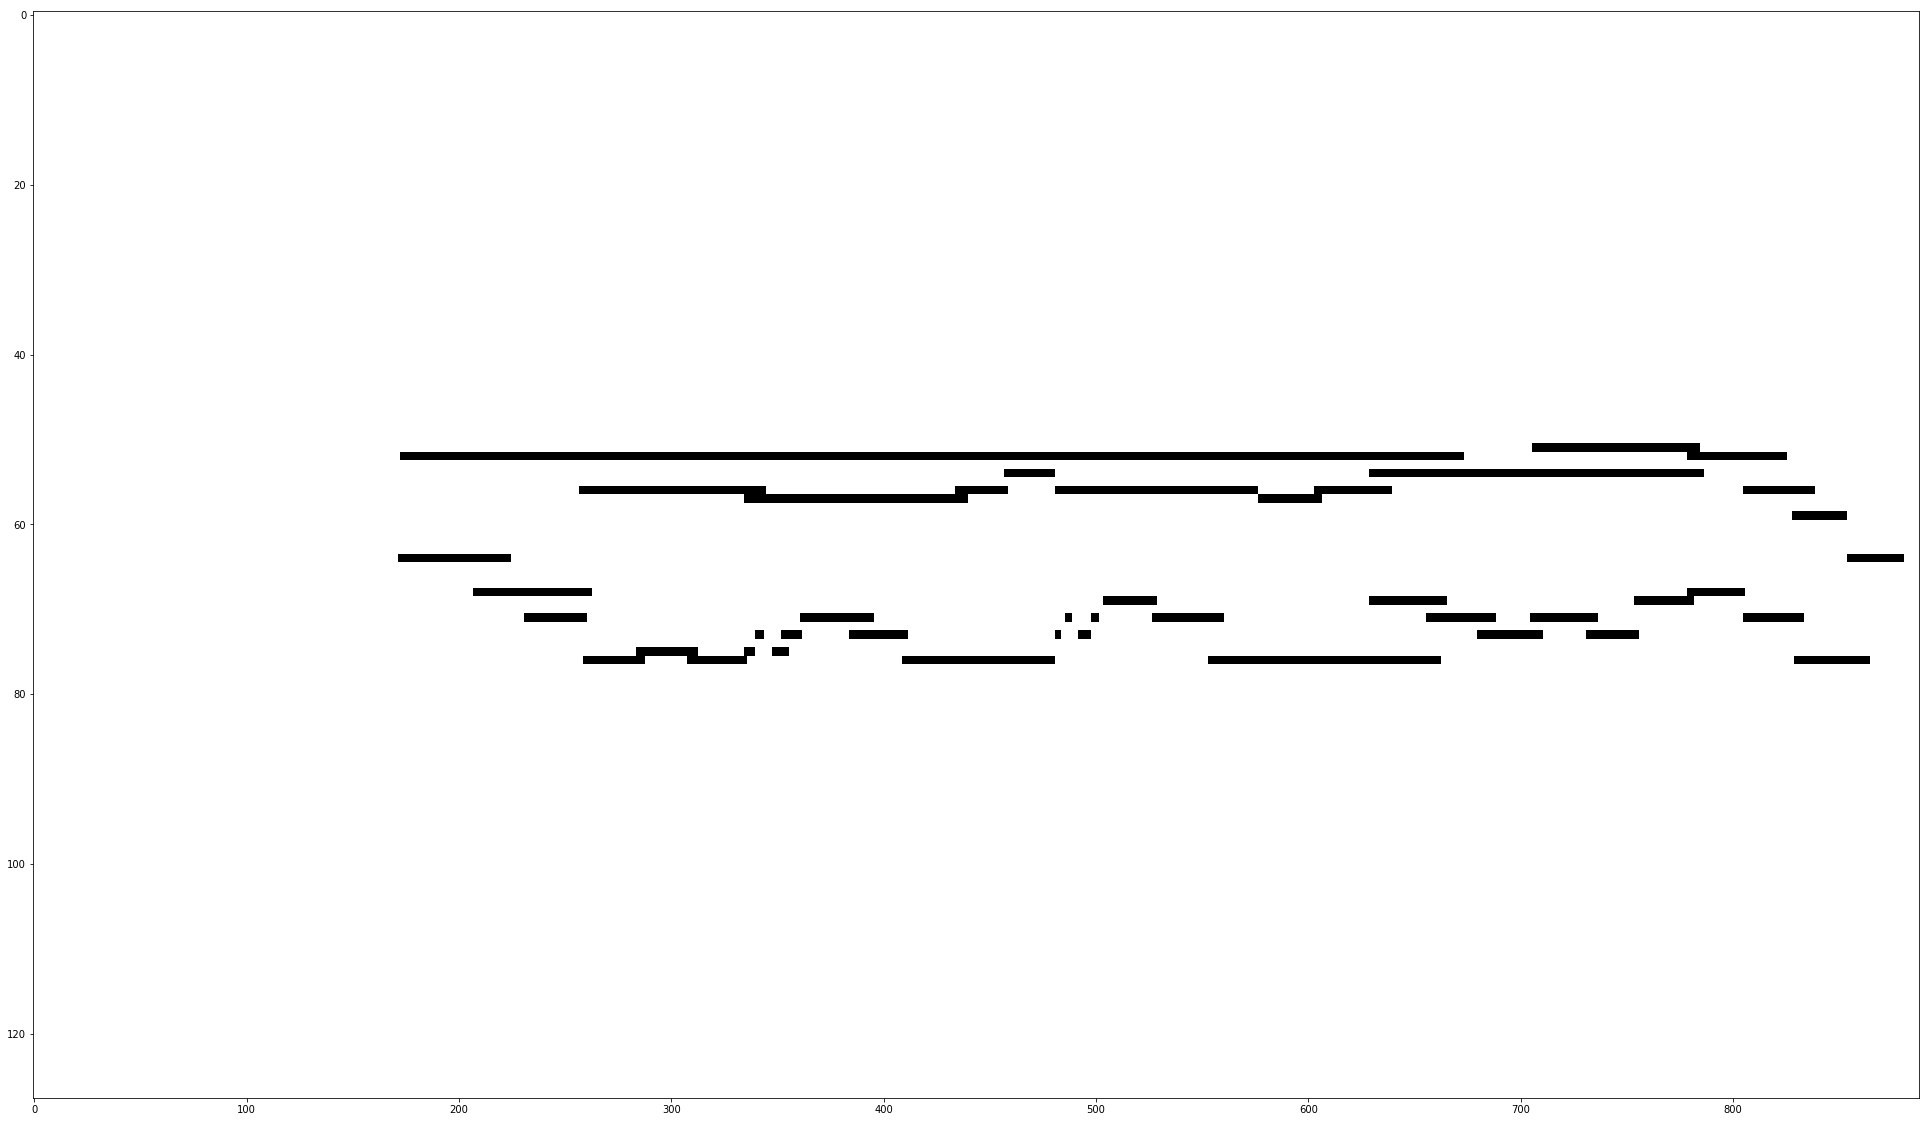

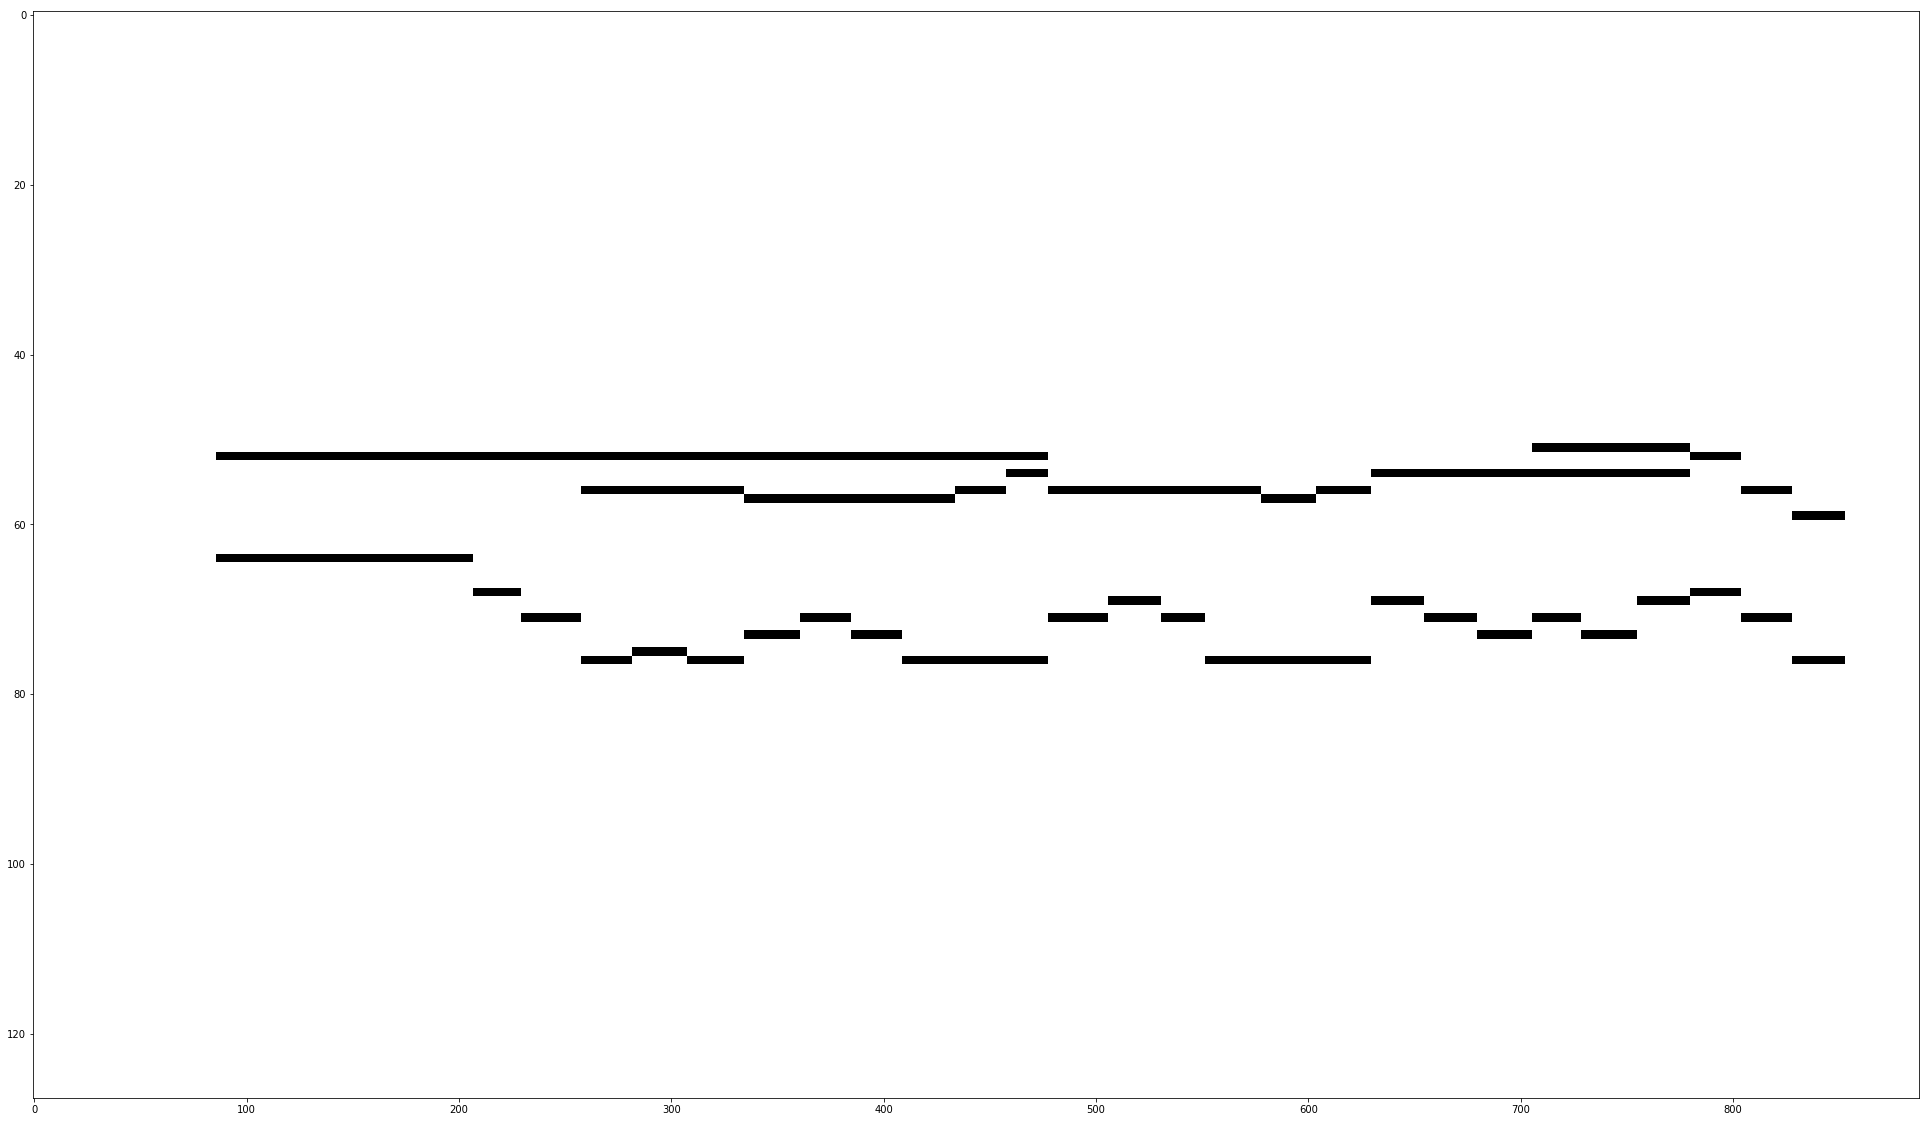

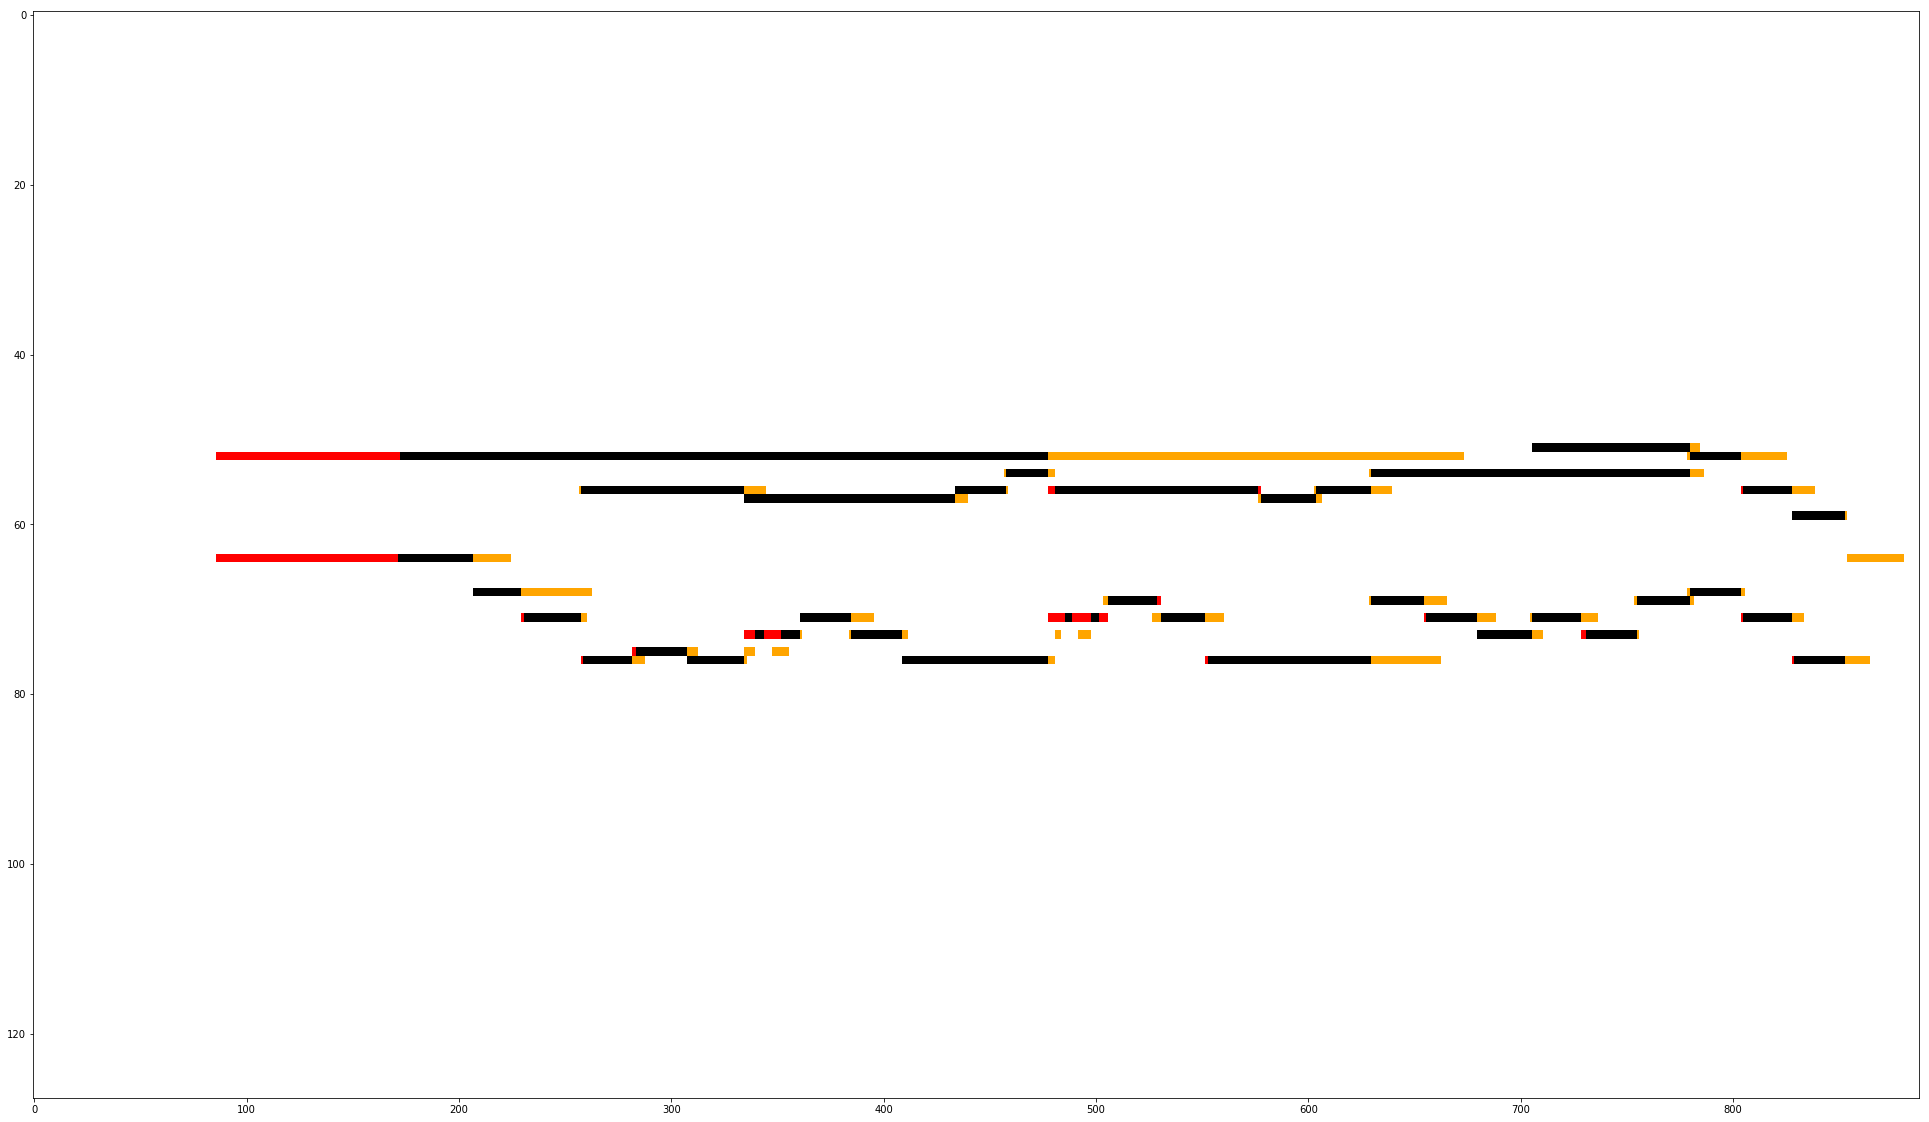

In [56]:
window_size=2048
stride=512
cutoff=int(50*(window_size/2048.))
record = './test/061_bwv854.wav'
synth = './test/bwv854_prelude_score.wav'

print('record', record)
print('synth', synth)
fs, data1 = wavfile.read(record)
left_pad = 1*fs
right_pad = 0*fs
data1 = data1[0:int(9.3*fs)]
data1 = np.concatenate((np.zeros((left_pad,2)),data1),axis=0)
frep1 = database.featurize(data1,fs,musiclib.feature,window_size,stride=stride,normalize=False)

fs, data2 = wavfile.read(synth)
data2 = data2[0:fs*10]
data2 = np.concatenate((np.zeros((left_pad,2)),data2),axis=0)
frep2 = database.featurize(data2,fs,musiclib.feature,window_size,stride=stride,normalize=False)

# Align signals
start = time.time()
L,P = align(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32))
end = time.time()
print('Elapsed time: ' + str(end - start))

# Find optimal path
path,costs = traceback_loss(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32),L)
path1 = np.array([x[0] for x in path])
path2 = np.array([x[1] for x in path])

# Find corresponding onsets on the performance
notes_onsets_offsets_2 = musiclib.load_midi('./test/bwv854_prelude_score.midi')
for i, e in list(enumerate(notes_onsets_offsets_2)):
    notes_onsets_offsets_2[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_1 = []    
for note, onset, offset in notes_onsets_offsets_2:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    sig2_onset_index = np.argmax(path2>=int(onset))
    sig2_offset_index = np.argmax(path2>=int(offset))
    sig1_onset = path1[sig2_onset_index]
    sig1_offset = path1[sig2_offset_index]
    notes_onsets_offsets_1.append((note, sig1_onset, sig1_offset))
notes_onsets_offsets_1 = np.array(notes_onsets_offsets_1)

# Find the correct onsets from the maestro midi file wtc1p19.mid
notes_onsets_offsets_correct = musiclib.load_midi('./test/061_bwv854.mid')

for i, e in list(enumerate(notes_onsets_offsets_correct)):
    notes_onsets_offsets_correct[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_correct_temp = []

for note, onset, offset in notes_onsets_offsets_correct:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    notes_onsets_offsets_correct_temp.append((note, onset, offset))
notes_onsets_offsets_correct = np.array(notes_onsets_offsets_correct_temp)

notes_onsets_offsets_correct = notes_onsets_offsets_correct.astype(int)


x = np.zeros((data1[:,0].shape[0], 128), dtype=bool)
y = np.zeros((data1[:,0].shape[0], 128), dtype=bool)

# Discretize maestro 
for note, onset, offset in notes_onsets_offsets_correct:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > x.shape[0] or offset > x.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        else:
            x[i][int(note)] = True  

# Discretize aligned midi         
for note, onset, offset in notes_onsets_offsets_1:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > y.shape[0] or offset > y.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        y[i][int(note)] = True

# Error conditions :
# 1) Something is playing in maestro and nothing is playing in alignment
# 2) Something is playing in alignment and nothing is playing in maestro
# This can be efficiently calculated using xor.

z = np.logical_xor(x[::512], y[::512])
print("Alignment Error: ", np.sum(z)) # total number of errors
print("Errors per second: ", np.sum(z)/(44100/512.)) # total number of errors
print("Errors per frame: ", np.sum(z)/len(z)) # total number of errors
plotColorMap(x, y, (200, 20))

# Performance 62 aligns properly

record ./test/062_bwv854.wav
synth ./test/bwv854_prelude_score.wav


/Users/harshverma/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Elapsed time: 0.03570413589477539
length of midi file94.5597952166669
length of midi file142.0104166666665
onset : 398848 offset 444416
onset : 410112 offset 421376
onset : 421376 offset 432128
Alignment Error:  673
Errors per second:  7.813514739229025
Errors per frame:  0.8217338217338217
white means no mistake
red means playing when not supposed to
orange means not playing when supposed to
black means playing when supposed to


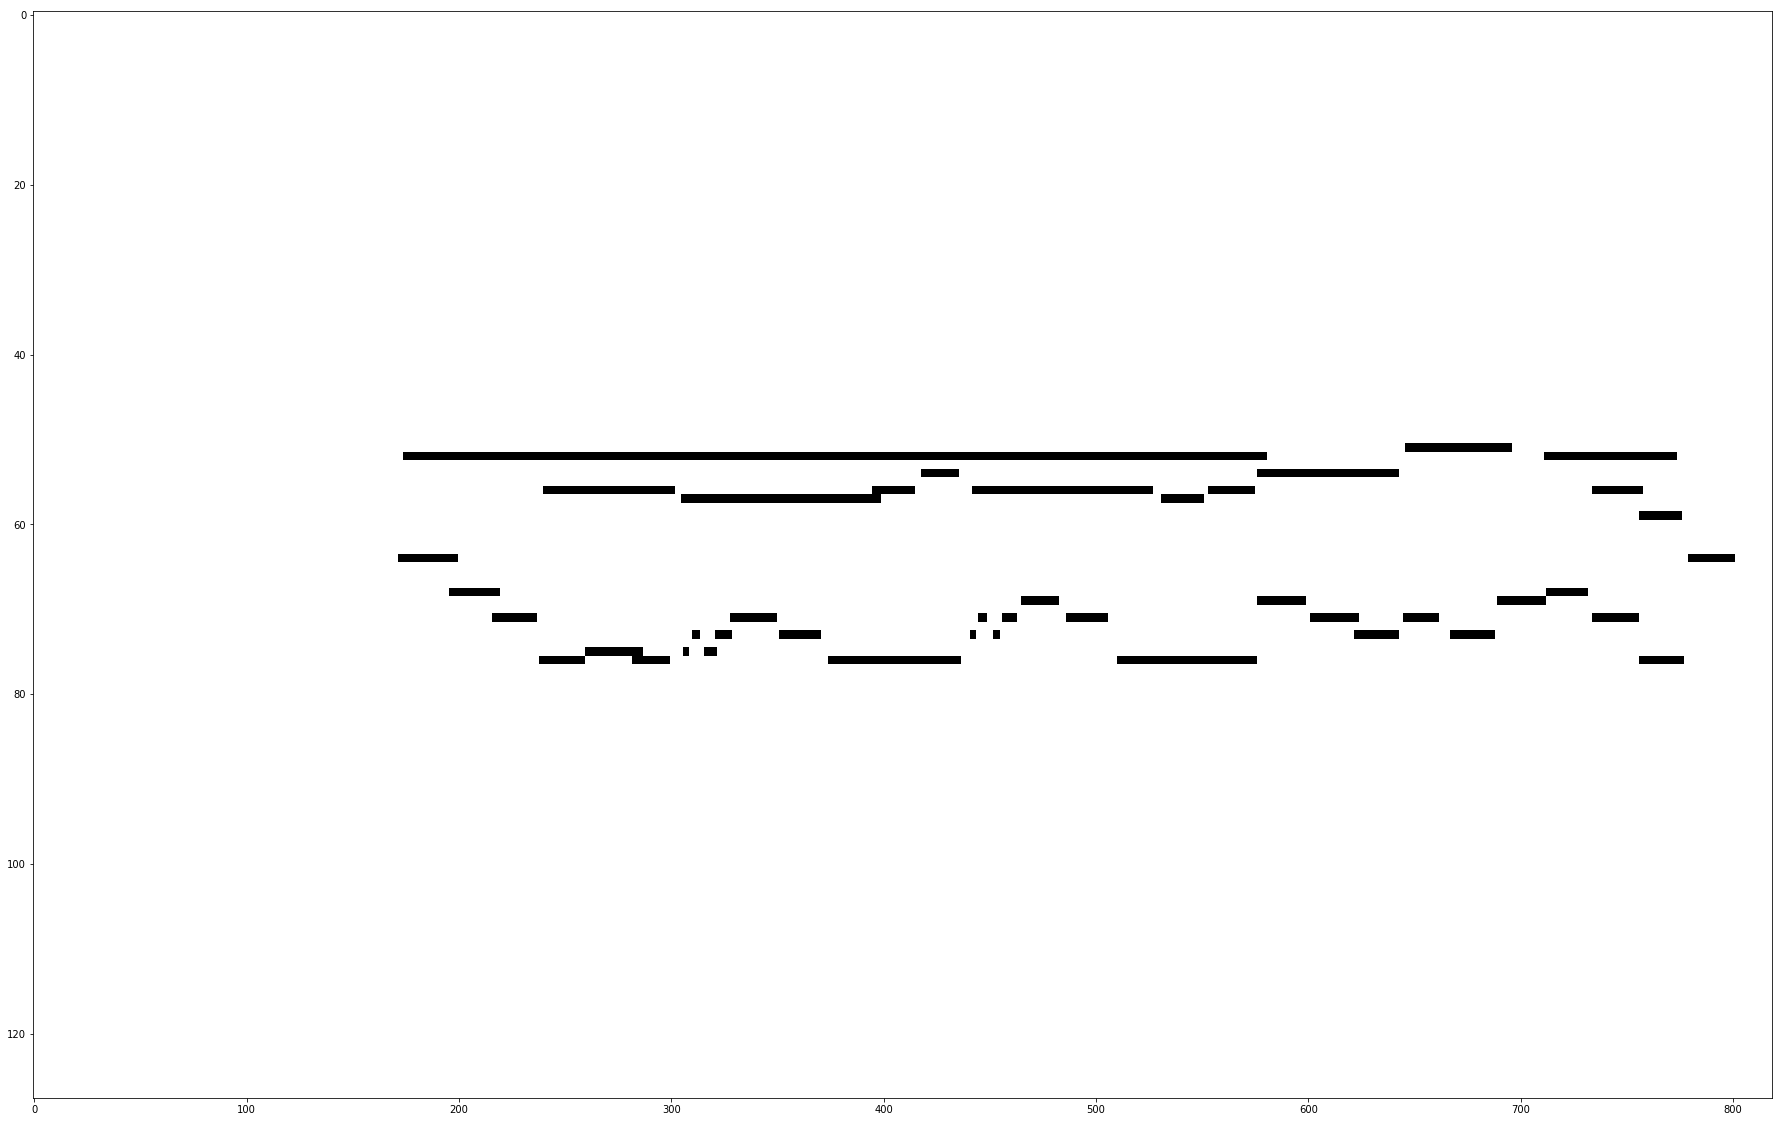

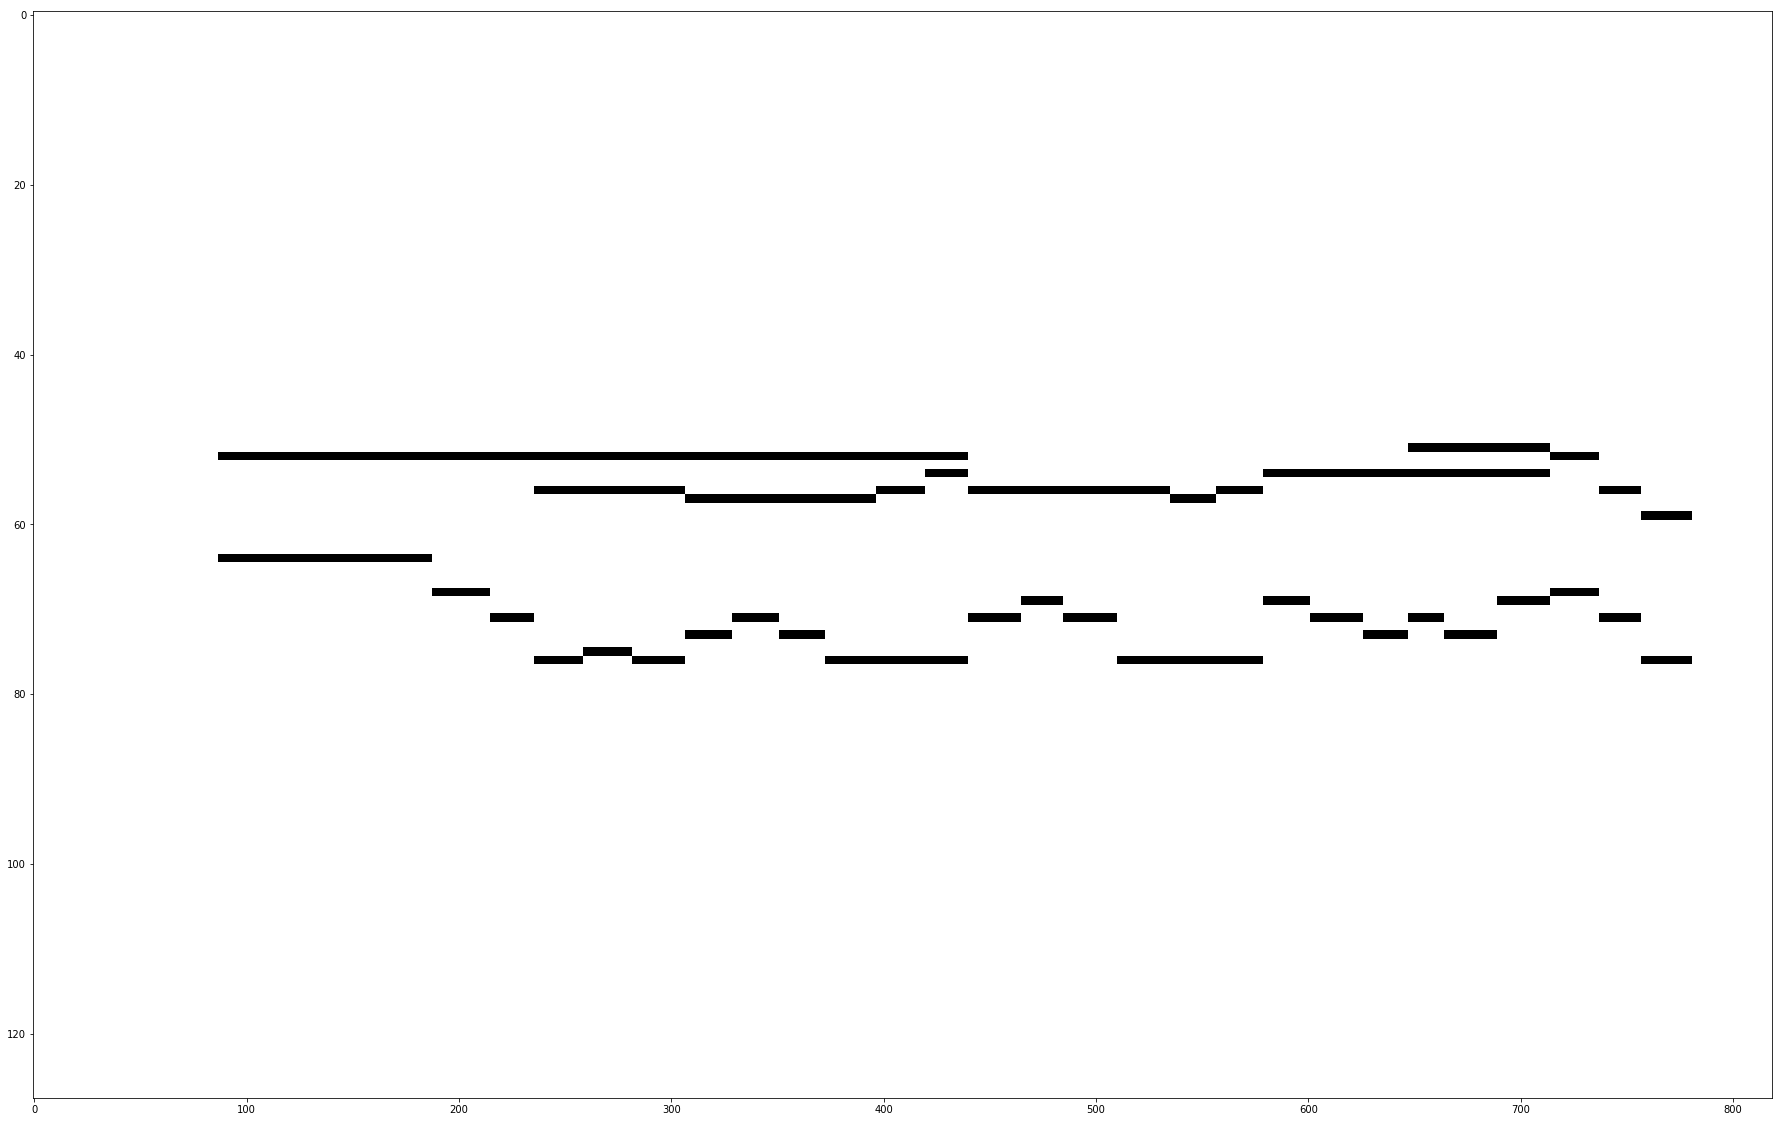

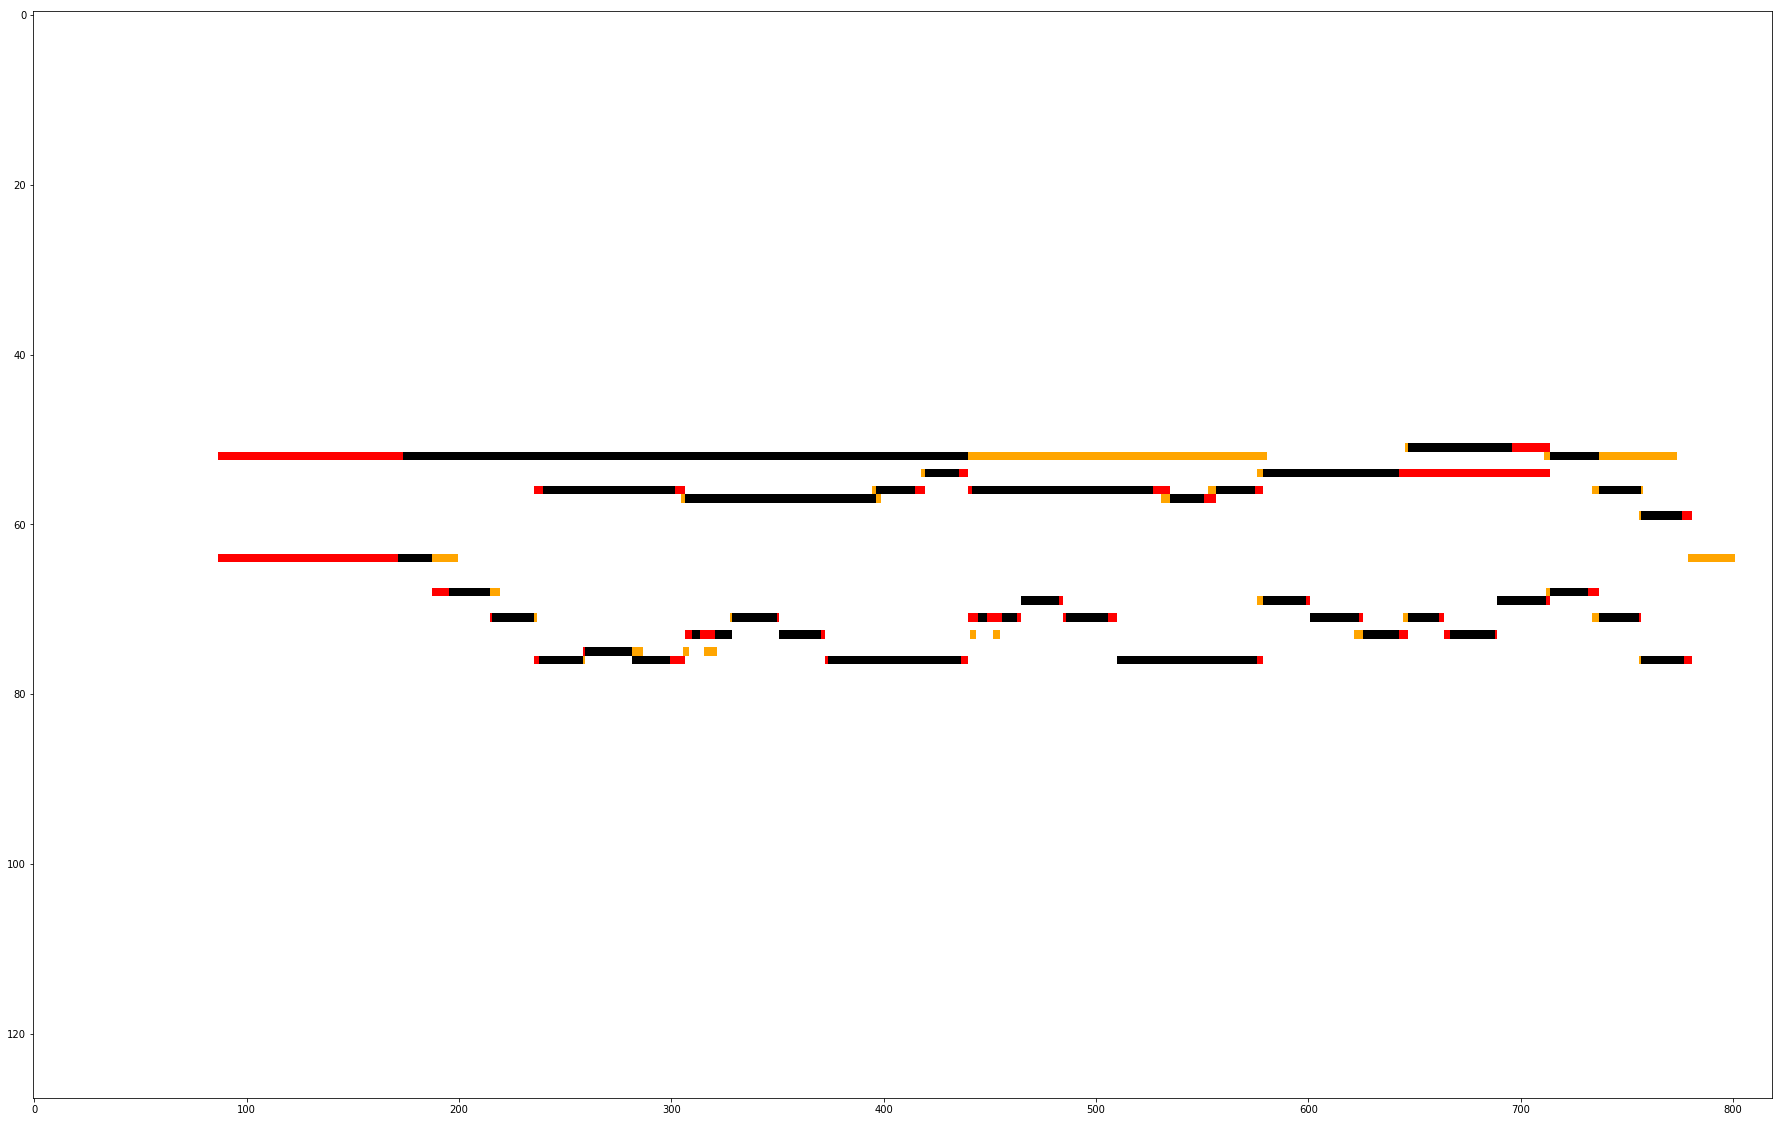

In [57]:
window_size=2048
stride=512
cutoff=int(50*(window_size/2048.))
record = './test/062_bwv854.wav'
synth = './test/bwv854_prelude_score.wav'

print('record', record)
print('synth', synth)
fs, data1 = wavfile.read(record)
left_pad = 1*fs
right_pad = 0*fs
data1 = data1[0:int(8.5*fs)]
data1 = np.concatenate((np.zeros((left_pad,2)),data1),axis=0)
frep1 = database.featurize(data1,fs,musiclib.feature,window_size,stride=stride,normalize=False)

fs, data2 = wavfile.read(synth)
data2 = data2[0:fs*10]
data2 = np.concatenate((np.zeros((left_pad,2)),data2),axis=0)
frep2 = database.featurize(data2,fs,musiclib.feature,window_size,stride=stride,normalize=False)

# Align signals
start = time.time()
L,P = align(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32))
end = time.time()
print('Elapsed time: ' + str(end - start))

# Find optimal path
path,costs = traceback_loss(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32),L)
path1 = np.array([x[0] for x in path])
path2 = np.array([x[1] for x in path])

# Find corresponding onsets on the performance
notes_onsets_offsets_2 = musiclib.load_midi('./test/bwv854_prelude_score.midi')
for i, e in list(enumerate(notes_onsets_offsets_2)):
    notes_onsets_offsets_2[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_1 = []    
for note, onset, offset in notes_onsets_offsets_2:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    sig2_onset_index = np.argmax(path2>=int(onset))
    sig2_offset_index = np.argmax(path2>=int(offset))
    sig1_onset = path1[sig2_onset_index]
    sig1_offset = path1[sig2_offset_index]
    notes_onsets_offsets_1.append((note, sig1_onset, sig1_offset))
notes_onsets_offsets_1 = np.array(notes_onsets_offsets_1)

# Find the correct onsets from the maestro midi file wtc1p19.mid
notes_onsets_offsets_correct = musiclib.load_midi('./test/062_bwv854.mid')

for i, e in list(enumerate(notes_onsets_offsets_correct)):
    notes_onsets_offsets_correct[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_correct_temp = []

for note, onset, offset in notes_onsets_offsets_correct:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    notes_onsets_offsets_correct_temp.append((note, onset, offset))
notes_onsets_offsets_correct = np.array(notes_onsets_offsets_correct_temp)

notes_onsets_offsets_correct = notes_onsets_offsets_correct.astype(int)


x = np.zeros((data1[:,0].shape[0], 128), dtype=bool)
y = np.zeros((data1[:,0].shape[0], 128), dtype=bool)

# Discretize maestro 
for note, onset, offset in notes_onsets_offsets_correct:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > x.shape[0] or offset > x.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        else:
            x[i][int(note)] = True  

# Discretize aligned midi         
for note, onset, offset in notes_onsets_offsets_1:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > y.shape[0] or offset > y.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        y[i][int(note)] = True

# Error conditions :
# 1) Something is playing in maestro and nothing is playing in alignment
# 2) Something is playing in alignment and nothing is playing in maestro
# This can be efficiently calculated using xor.

z = np.logical_xor(x[::512], y[::512])
print("Alignment Error: ", np.sum(z)) # total number of errors
print("Errors per second: ", np.sum(z)/(44100/512.)) # total number of errors
print("Errors per frame: ", np.sum(z)/len(z)) # total number of errors
plotColorMap(x, y, (200, 20))

# Performance 63 aligns properly

record ./test/063_bwv854.wav
synth ./test/bwv854_prelude_score.wav


/Users/harshverma/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Elapsed time: 0.04320693016052246
length of midi file94.5597952166669
length of midi file145.30338541666632
Alignment Error:  891
Errors per second:  10.344489795918367
Errors per frame:  1.0033783783783783
white means no mistake
red means playing when not supposed to
orange means not playing when supposed to
black means playing when supposed to


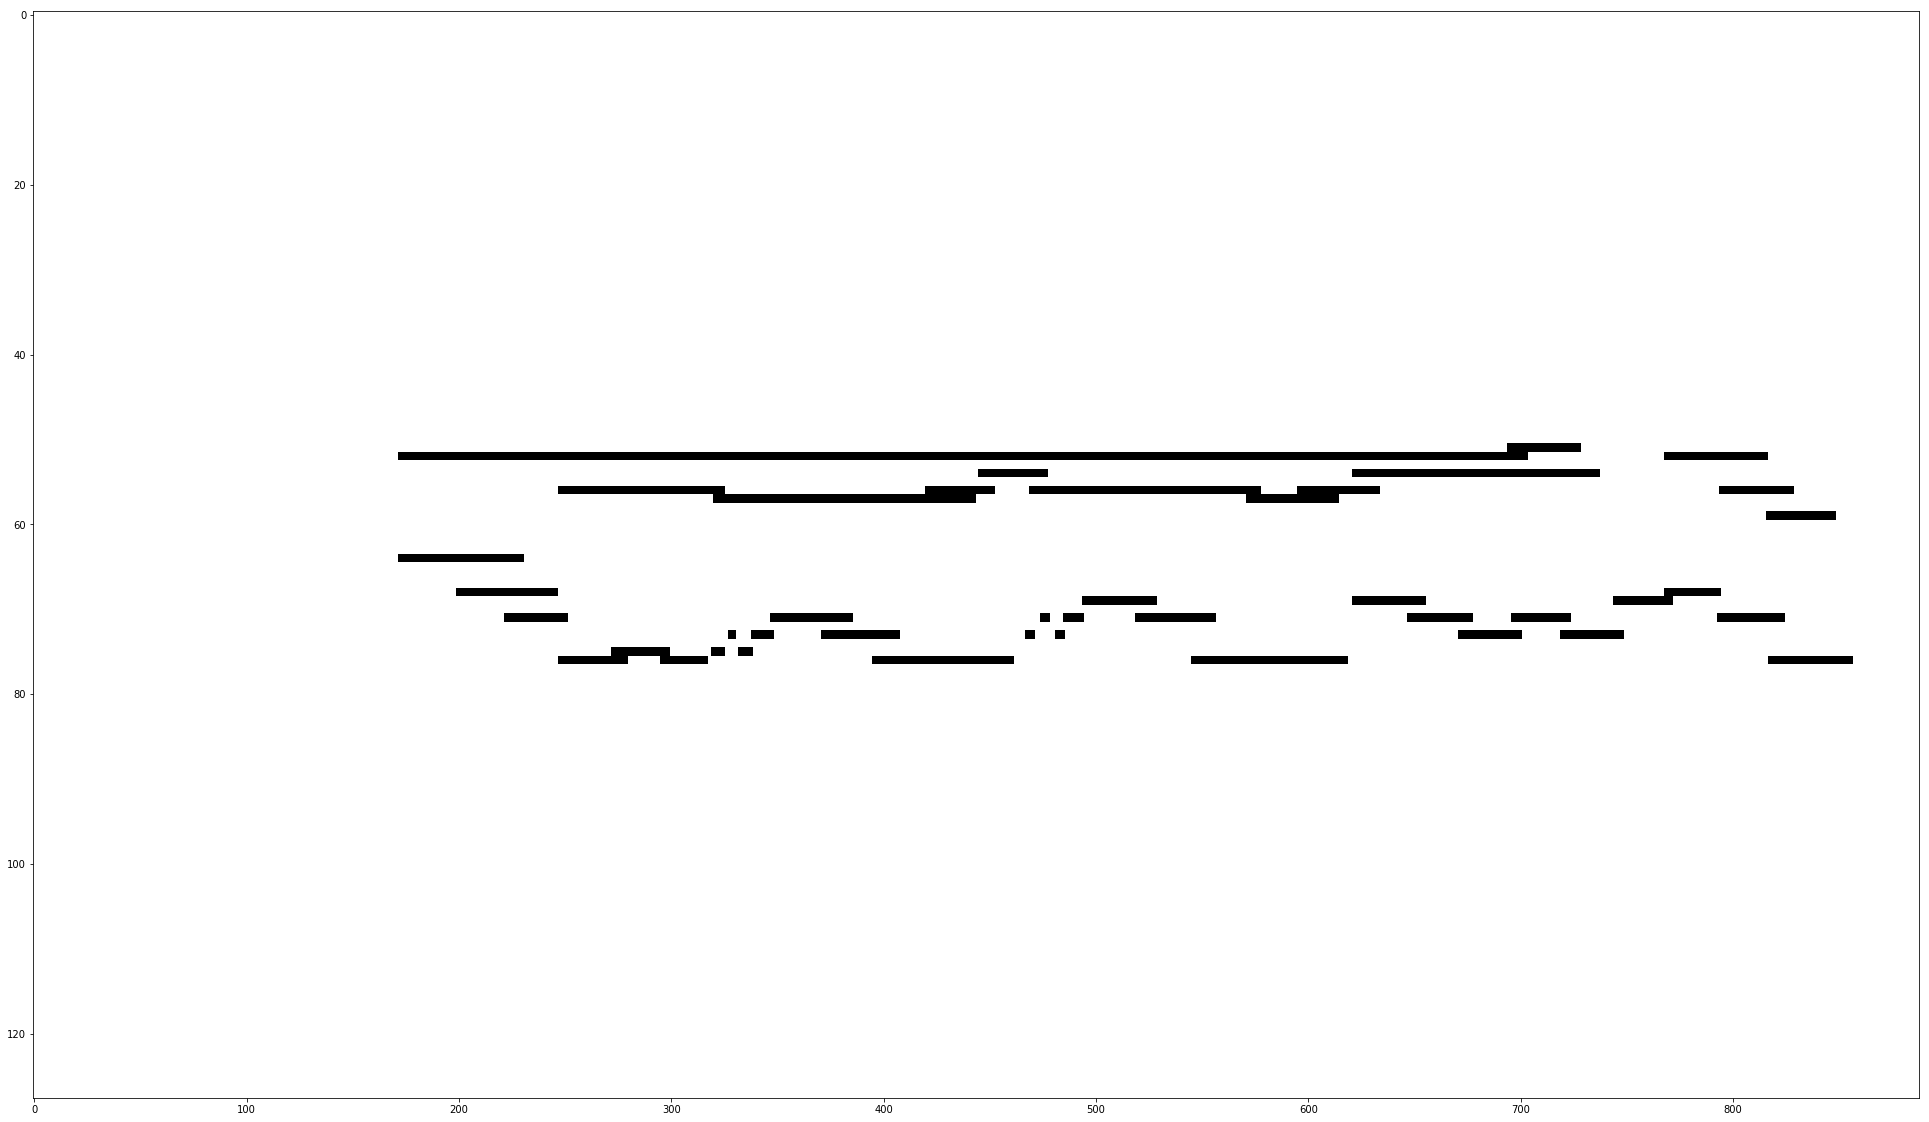

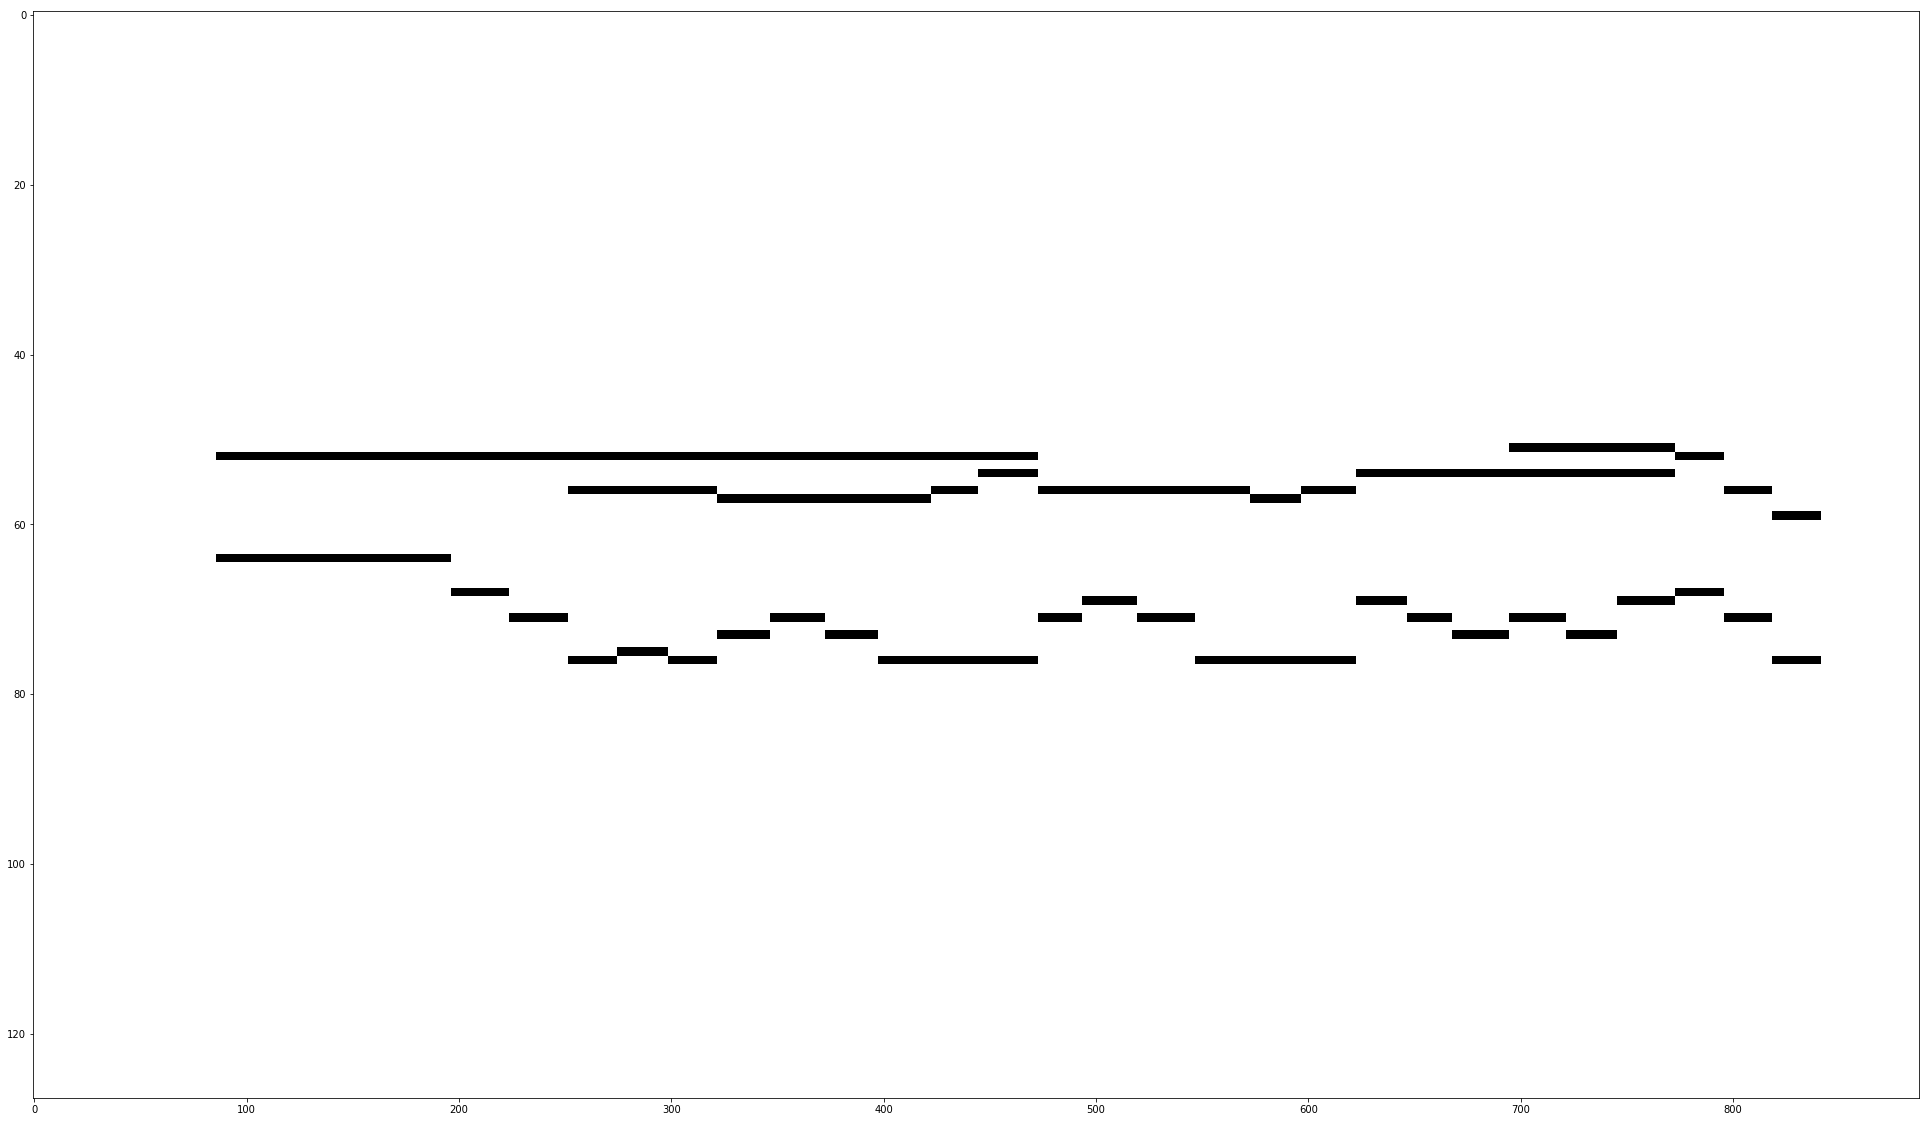

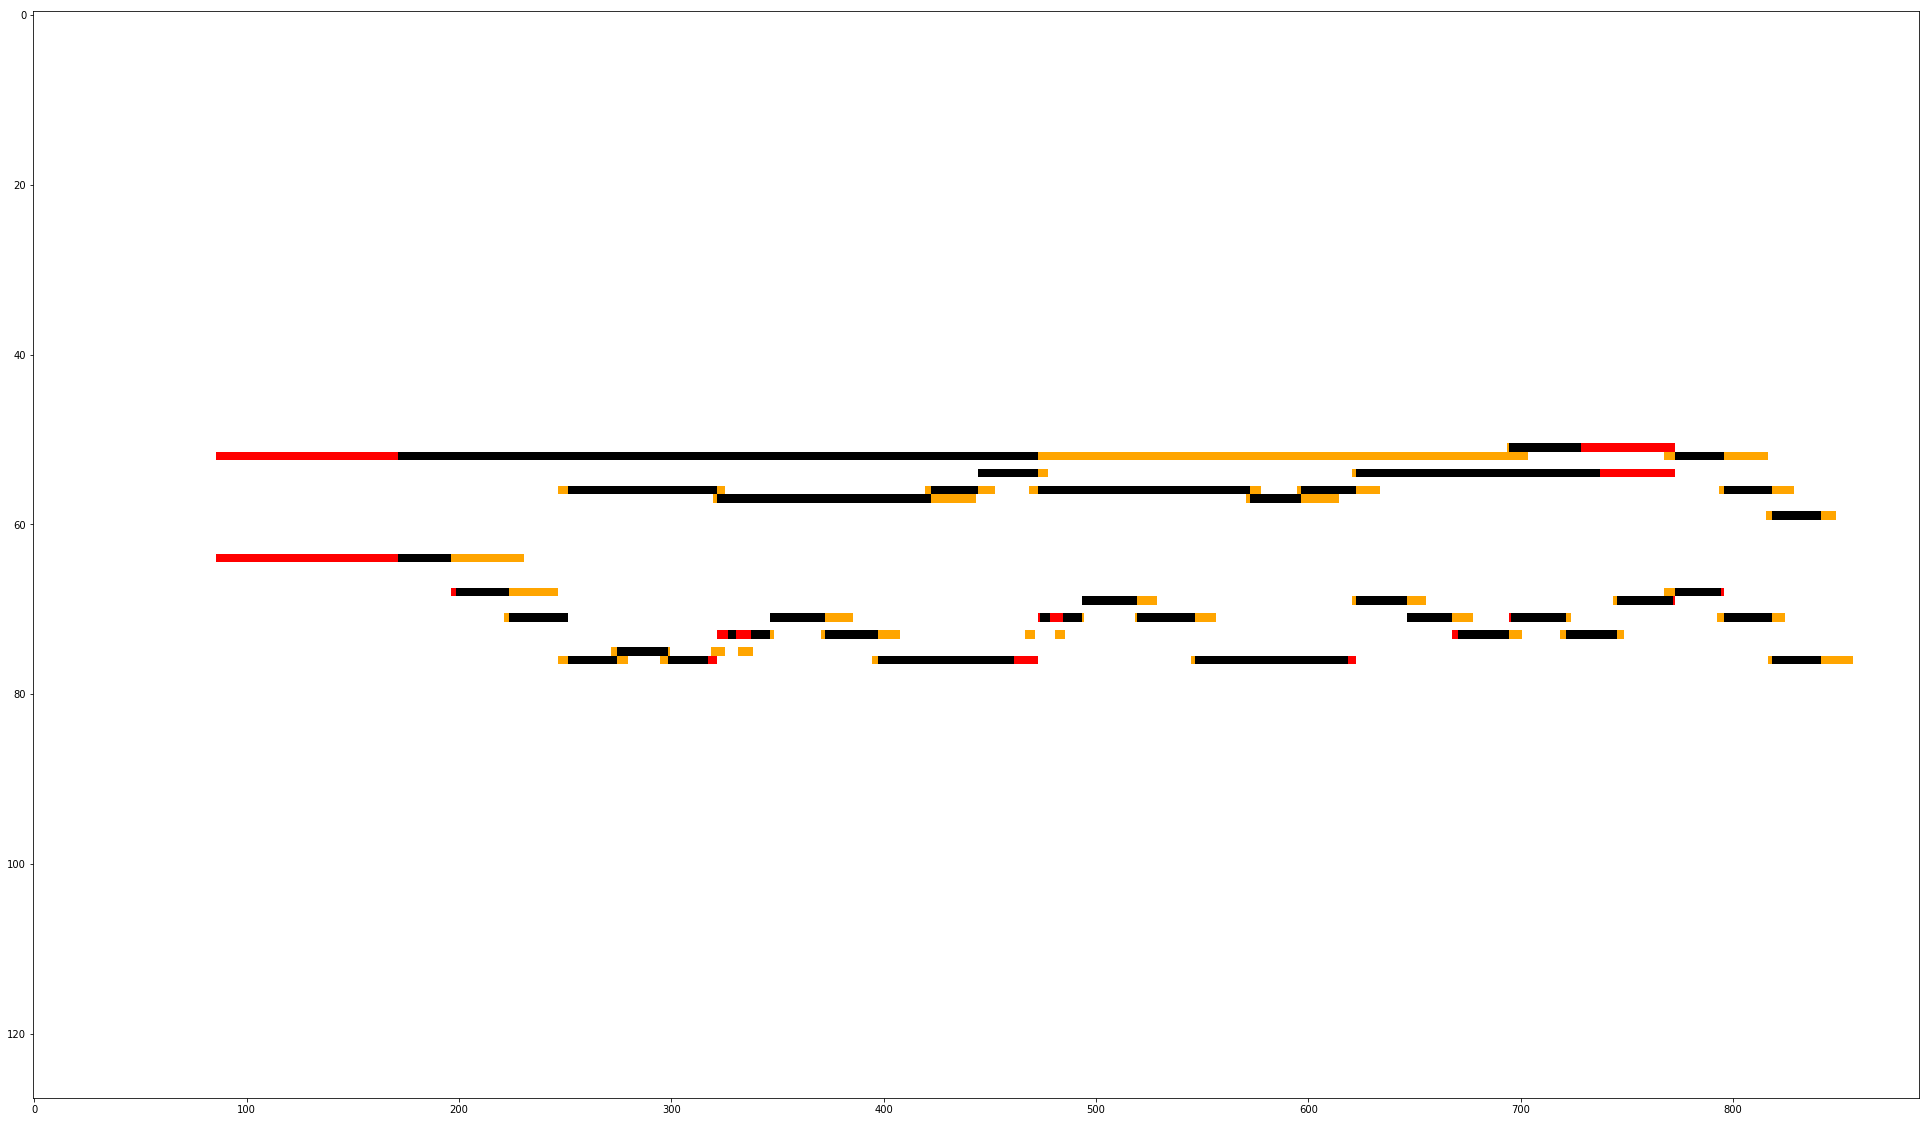

In [58]:
window_size=2048
stride=512
cutoff=int(50*(window_size/2048.))
record = './test/063_bwv854.wav'
synth = './test/bwv854_prelude_score.wav'

print('record', record)
print('synth', synth)
fs, data1 = wavfile.read(record)
left_pad = 1*fs
right_pad = 0*fs
data1 = data1[0:int(9.3*fs)]
data1 = np.concatenate((np.zeros((left_pad,2)),data1),axis=0)
frep1 = database.featurize(data1,fs,musiclib.feature,window_size,stride=stride,normalize=False)

fs, data2 = wavfile.read(synth)
data2 = data2[0:fs*10]
data2 = np.concatenate((np.zeros((left_pad,2)),data2),axis=0)
frep2 = database.featurize(data2,fs,musiclib.feature,window_size,stride=stride,normalize=False)

# Align signals
start = time.time()
L,P = align(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32))
end = time.time()
print('Elapsed time: ' + str(end - start))

# Find optimal path
path,costs = traceback_loss(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32),L)
path1 = np.array([x[0] for x in path])
path2 = np.array([x[1] for x in path])

# Find corresponding onsets on the performance
notes_onsets_offsets_2 = musiclib.load_midi('./test/bwv854_prelude_score.midi')
for i, e in list(enumerate(notes_onsets_offsets_2)):
    notes_onsets_offsets_2[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_1 = []    
for note, onset, offset in notes_onsets_offsets_2:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    sig2_onset_index = np.argmax(path2>=int(onset))
    sig2_offset_index = np.argmax(path2>=int(offset))
    sig1_onset = path1[sig2_onset_index]
    sig1_offset = path1[sig2_offset_index]
    notes_onsets_offsets_1.append((note, sig1_onset, sig1_offset))
notes_onsets_offsets_1 = np.array(notes_onsets_offsets_1)

# Find the correct onsets from the maestro midi file wtc1p19.mid
notes_onsets_offsets_correct = musiclib.load_midi('./test/063_bwv854.mid')

for i, e in list(enumerate(notes_onsets_offsets_correct)):
    notes_onsets_offsets_correct[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_correct_temp = []

for note, onset, offset in notes_onsets_offsets_correct:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    notes_onsets_offsets_correct_temp.append((note, onset, offset))
notes_onsets_offsets_correct = np.array(notes_onsets_offsets_correct_temp)

notes_onsets_offsets_correct = notes_onsets_offsets_correct.astype(int)


x = np.zeros((data1[:,0].shape[0], 128), dtype=bool)
y = np.zeros((data1[:,0].shape[0], 128), dtype=bool)

# Discretize maestro 
for note, onset, offset in notes_onsets_offsets_correct:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > x.shape[0] or offset > x.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        else:
            x[i][int(note)] = True  

# Discretize aligned midi         
for note, onset, offset in notes_onsets_offsets_1:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > y.shape[0] or offset > y.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        y[i][int(note)] = True

# Error conditions :
# 1) Something is playing in maestro and nothing is playing in alignment
# 2) Something is playing in alignment and nothing is playing in maestro
# This can be efficiently calculated using xor.

z = np.logical_xor(x[::512], y[::512])
print("Alignment Error: ", np.sum(z)) # total number of errors
print("Errors per second: ", np.sum(z)/(44100/512.)) # total number of errors
print("Errors per frame: ", np.sum(z)/len(z)) # total number of errors
plotColorMap(x, y, (200, 20))

# Performace 64 DOES NOT align properly

record ./test/064_bwv854.wav
synth ./test/bwv854_prelude_score.wav


/Users/harshverma/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Elapsed time: 0.12851405143737793
length of midi file94.5597952166669
length of midi file151.0010416666664
onset : 651776 offset 836096
onset : 756736 offset 794112
onset : 768512 offset 780288
onset : 780288 offset 794624
onset : 792576 offset 805376
onset : 793600 offset 900096
onset : 804352 offset 817152
onset : 816128 offset 828416
onset : 827392 offset 838656
onset : 838656 offset 850944
onset : 849920 offset 857088
onset : 850432 offset 864256
onset : 863232 offset 876544
onset : 863744 offset 913408
onset : 875520 offset 889344
onset : 887808 offset 899584
Alignment Error:  3709
Errors per second:  43.06140589569161
Errors per frame:  2.4417379855167876
white means no mistake
red means playing when not supposed to
orange means not playing when supposed to
black means playing when supposed to


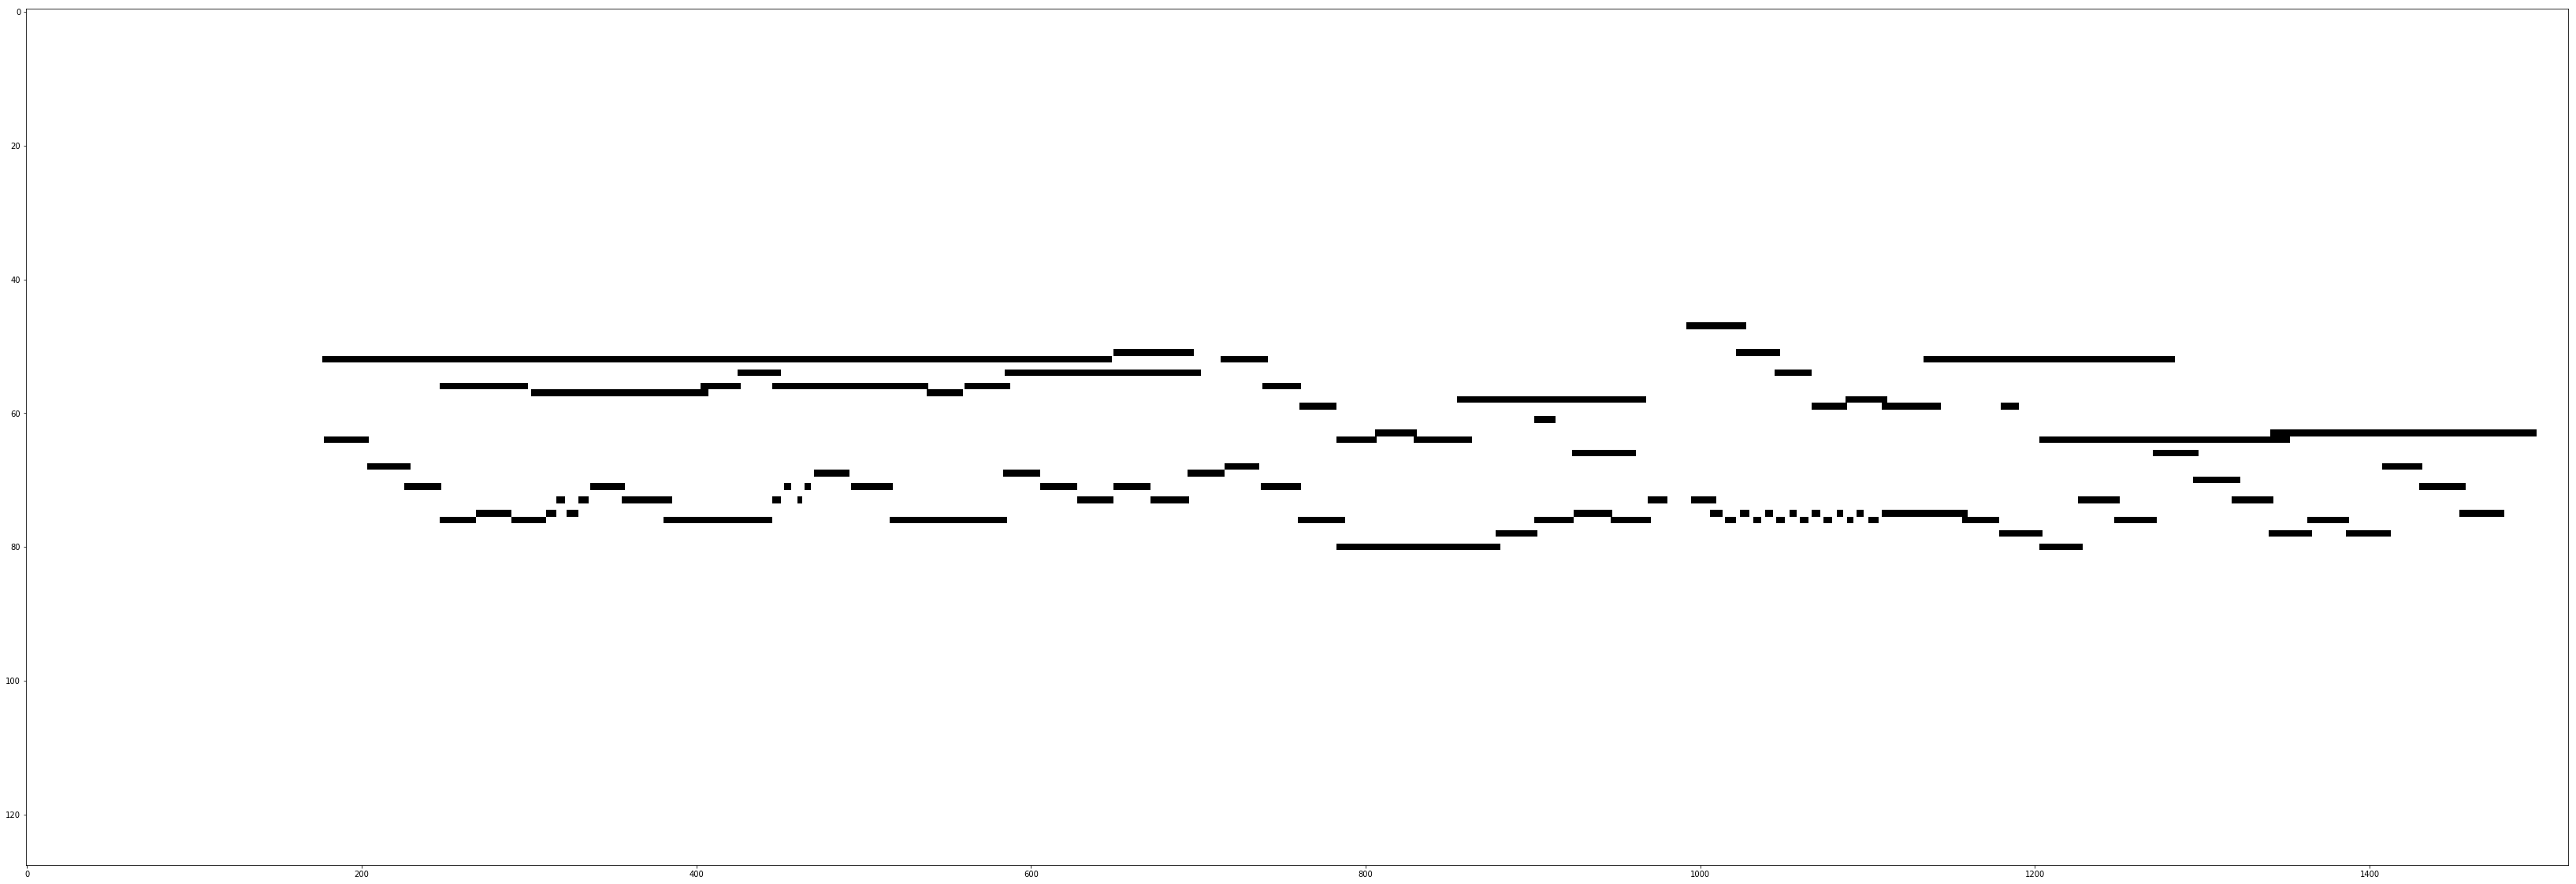

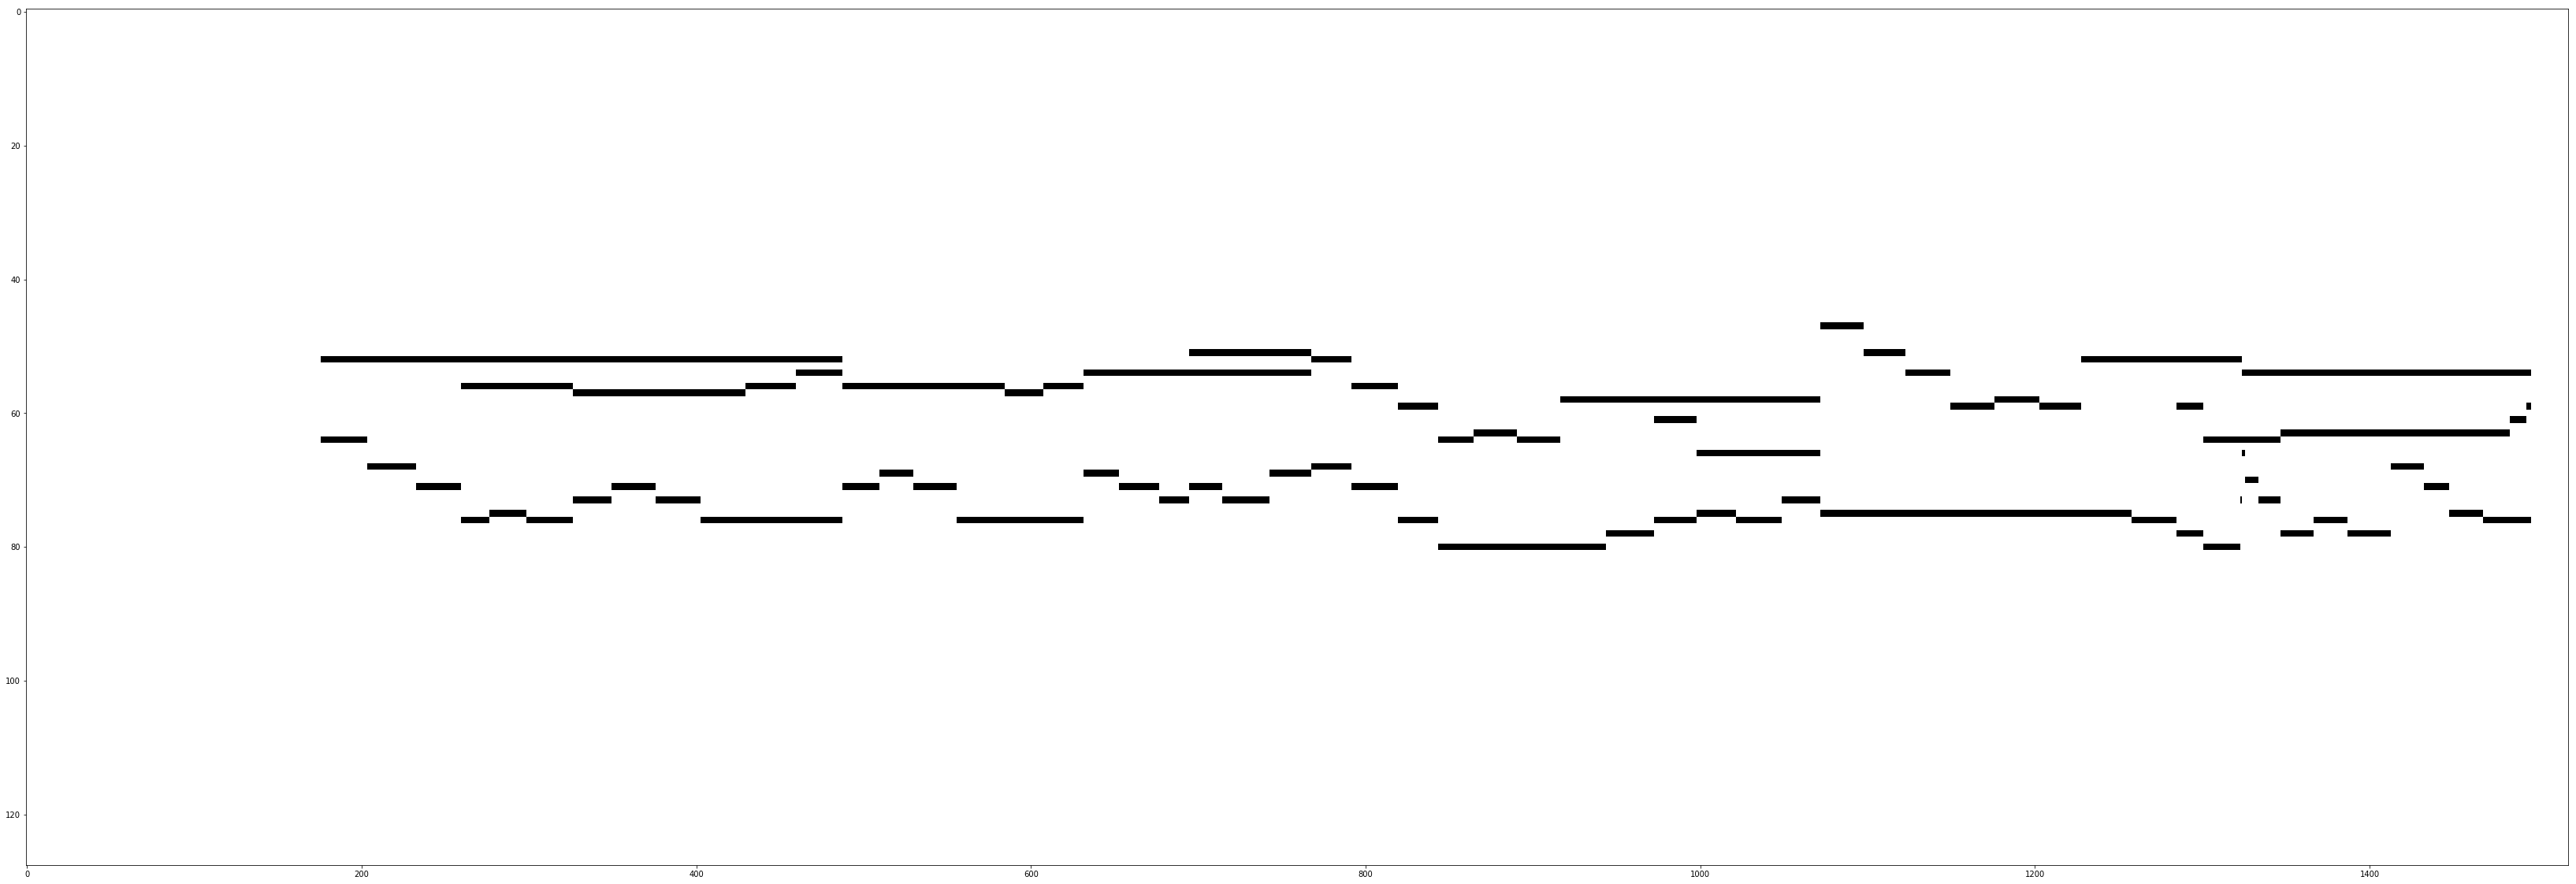

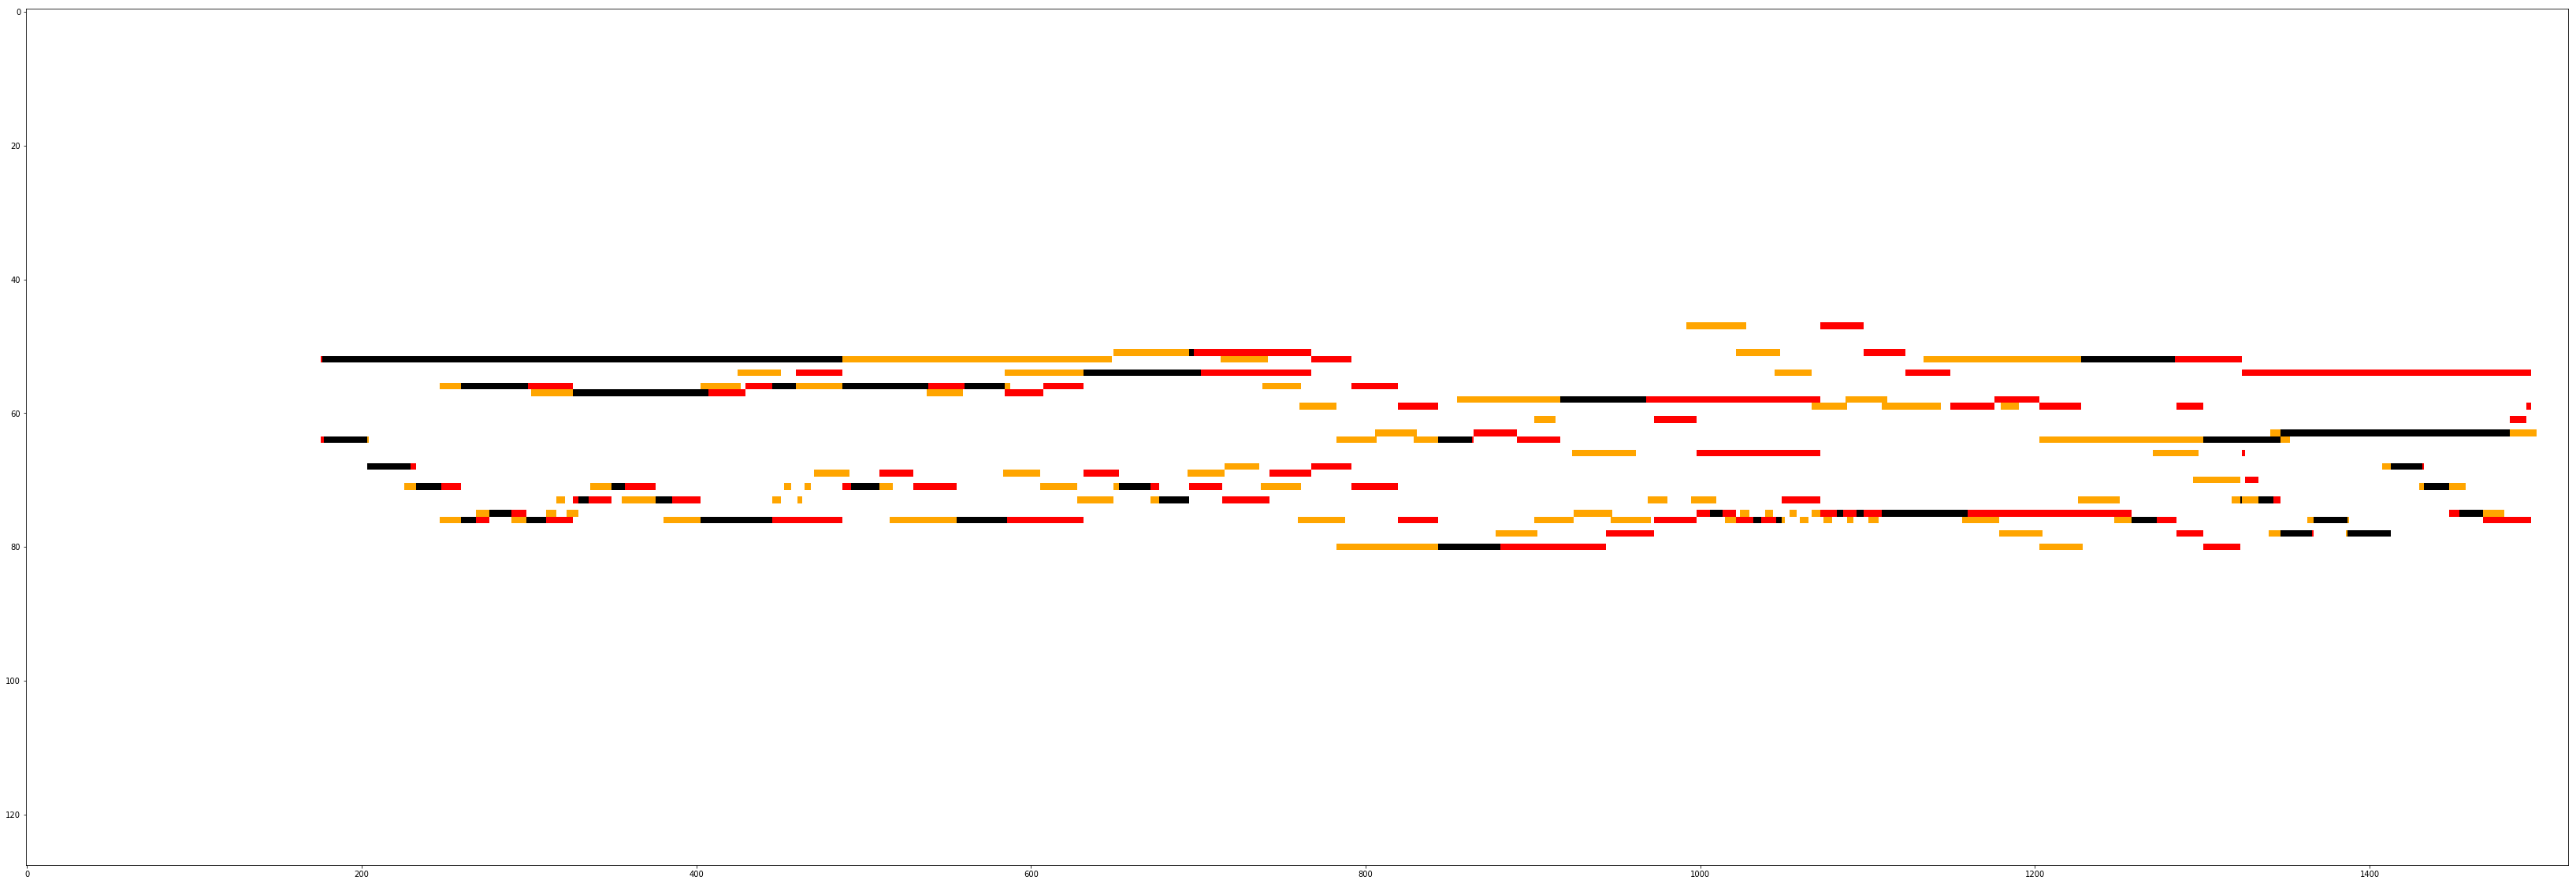

In [62]:
window_size=2048
stride=512
cutoff=int(50*(window_size/2048.))
record = './test/064_bwv854.wav'
synth = './test/bwv854_prelude_score.wav'

print('record', record)
print('synth', synth)
fs, data1 = wavfile.read(record)
left_pad = 1*fs
right_pad = 0*fs
data1 = data1[0:int(15.2*fs)]
data1 = np.concatenate((np.zeros((left_pad,2)),data1),axis=0)
frep1 = database.featurize(data1,fs,musiclib.feature,window_size,stride=stride,normalize=False)

fs, data2 = wavfile.read(synth)
data2 = data2[0:fs*20]
data2 = np.concatenate((np.zeros((left_pad,2)),data2),axis=0)
frep2 = database.featurize(data2,fs,musiclib.feature,window_size,stride=stride,normalize=False)

# Align signals
start = time.time()
L,P = align(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32))
end = time.time()
print('Elapsed time: ' + str(end - start))

# Find optimal path
path,costs = traceback_loss(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32),L)
path1 = np.array([x[0] for x in path])
path2 = np.array([x[1] for x in path])

# Find corresponding onsets on the performance
notes_onsets_offsets_2 = musiclib.load_midi('./test/bwv854_prelude_score.midi')
for i, e in list(enumerate(notes_onsets_offsets_2)):
    notes_onsets_offsets_2[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_1 = []    
for note, onset, offset in notes_onsets_offsets_2:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    sig2_onset_index = np.argmax(path2>=int(onset))
    sig2_offset_index = np.argmax(path2>=int(offset))
    sig1_onset = path1[sig2_onset_index]
    sig1_offset = path1[sig2_offset_index]
    notes_onsets_offsets_1.append((note, sig1_onset, sig1_offset))
notes_onsets_offsets_1 = np.array(notes_onsets_offsets_1)

# Find the correct onsets from the maestro midi file wtc1p19.mid
notes_onsets_offsets_correct = musiclib.load_midi('./bach_wtc_2/064_bwv854.mid')

for i, e in list(enumerate(notes_onsets_offsets_correct)):
    notes_onsets_offsets_correct[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_correct_temp = []

for note, onset, offset in notes_onsets_offsets_correct:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    notes_onsets_offsets_correct_temp.append((note, onset, offset))
notes_onsets_offsets_correct = np.array(notes_onsets_offsets_correct_temp)

notes_onsets_offsets_correct = notes_onsets_offsets_correct.astype(int)

x = np.zeros((data1[:,0].shape[0], 128), dtype=bool)
y = np.zeros((data1[:,0].shape[0], 128), dtype=bool)

# Discretize maestro 
for note, onset, offset in notes_onsets_offsets_correct:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > x.shape[0] or offset > x.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        else:
            x[i][int(note)] = True  

# Discretize aligned midi         
for note, onset, offset in notes_onsets_offsets_1:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > y.shape[0] or offset > y.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        y[i][int(note)] = True

# Error conditions :
# 1) Something is playing in maestro and nothing is playing in alignment
# 2) Something is playing in alignment and nothing is playing in maestro
# This can be efficiently calculated using xor.

z = np.logical_xor(x[::512], y[::512])
print("Alignment Error: ", np.sum(z)) # total number of errors
print("Errors per second: ", np.sum(z)/(44100/512.)) # total number of errors
print("Errors per frame: ", np.sum(z)/len(z)) # total number of errors
plotColorMap(x, y, (200, 20))

In [28]:
Audio(data1[:,0],rate=fs)

In [29]:
Audio(data2[:,0],rate=fs)

# Performace 65 DOES NOT align properly

record ./test/065_bwv854.wav
synth ./test/bwv854_prelude_score.wav


/Users/harshverma/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Elapsed time: 0.15482592582702637
length of midi file94.5597952166669
length of midi file151.10937499999935
onset : 644608 offset 843264
onset : 784384 offset 888832
onset : 807424 offset 817664
onset : 819200 offset 827392
onset : 830464 offset 840704
onset : 842240 offset 854016
onset : 842240 offset 852480
onset : 854016 offset 867840
onset : 854016 offset 900608
onset : 866304 offset 877056
onset : 877568 offset 886784
onset : 889856 offset 934400
onset : 889856 offset 938496
onset : 901632 offset 912896
onset : 913408 offset 920064
Alignment Error:  4172
Errors per second:  48.4368253968254
Errors per frame:  2.617314930991217
white means no mistake
red means playing when not supposed to
orange means not playing when supposed to
black means playing when supposed to


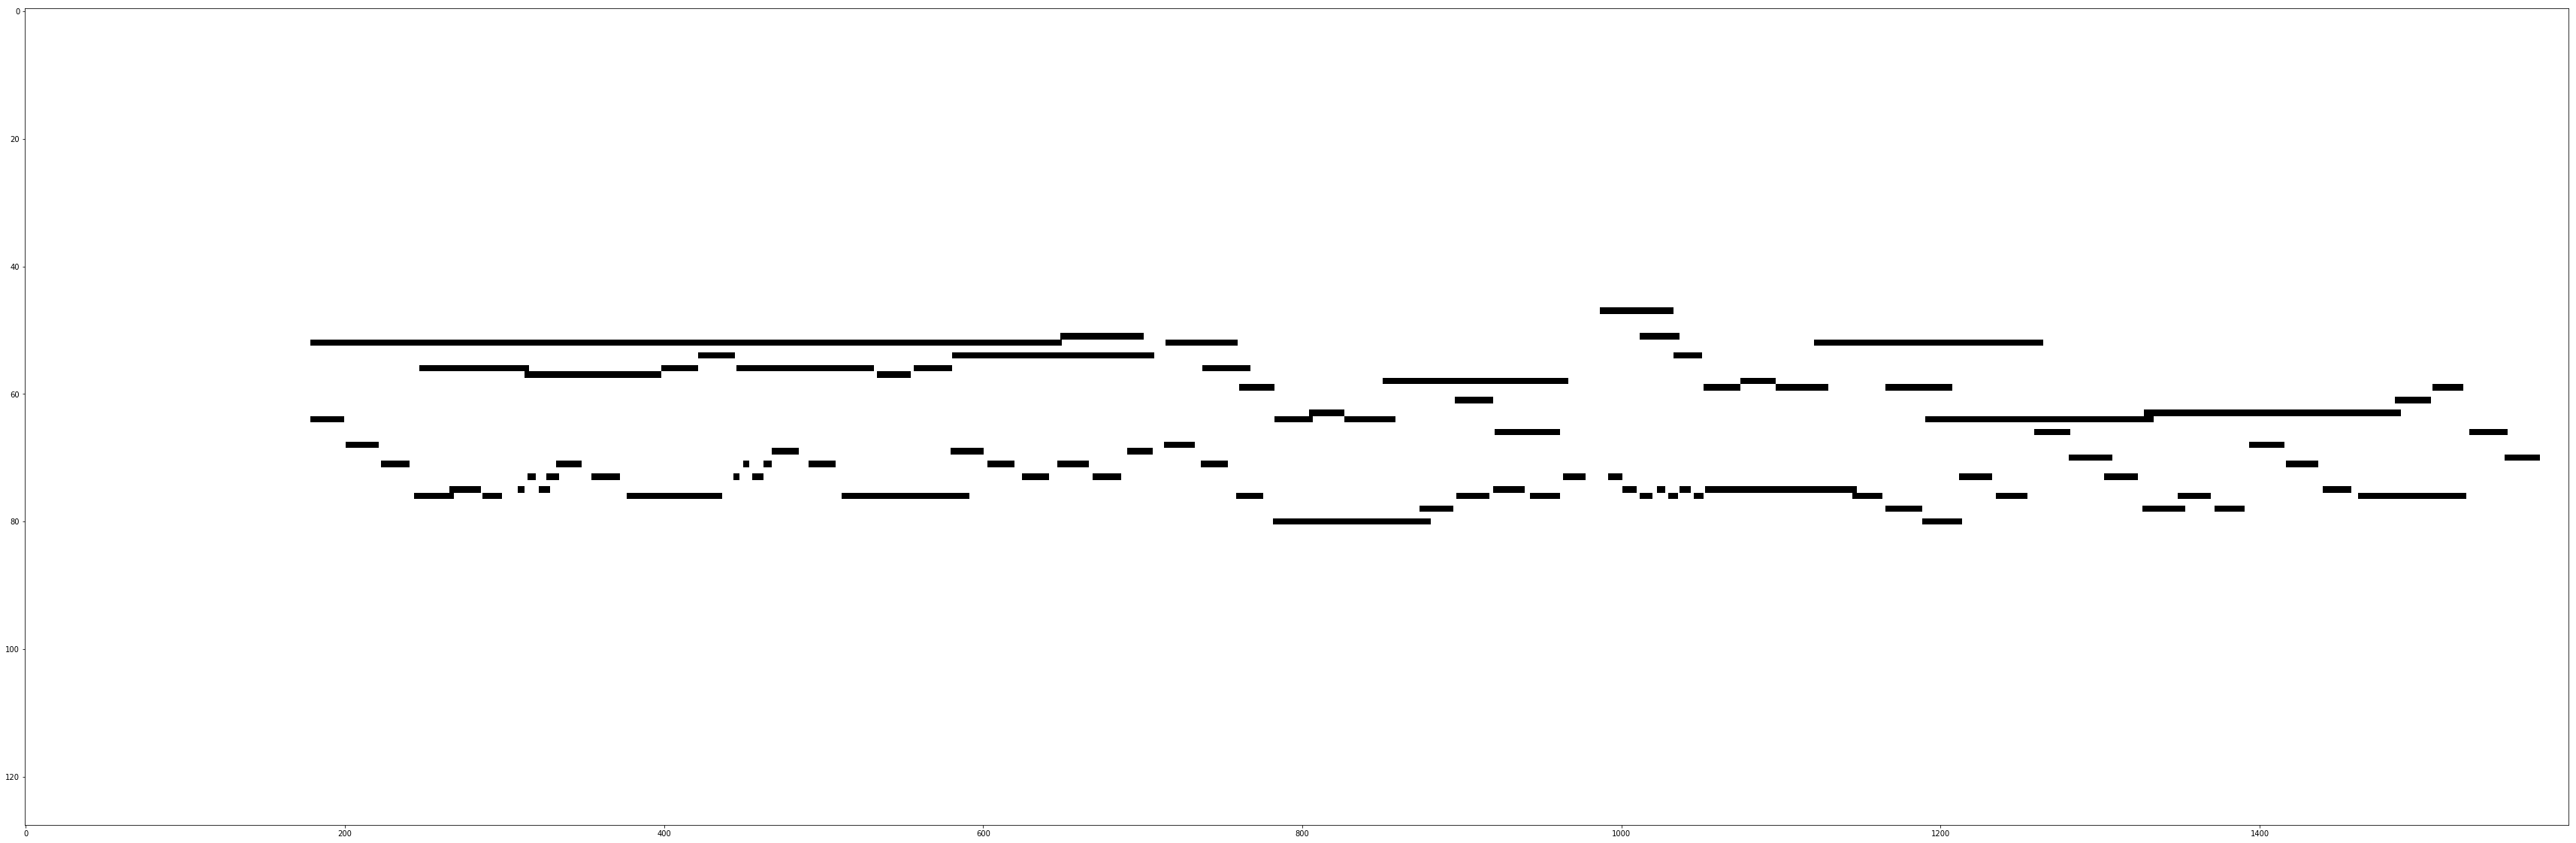

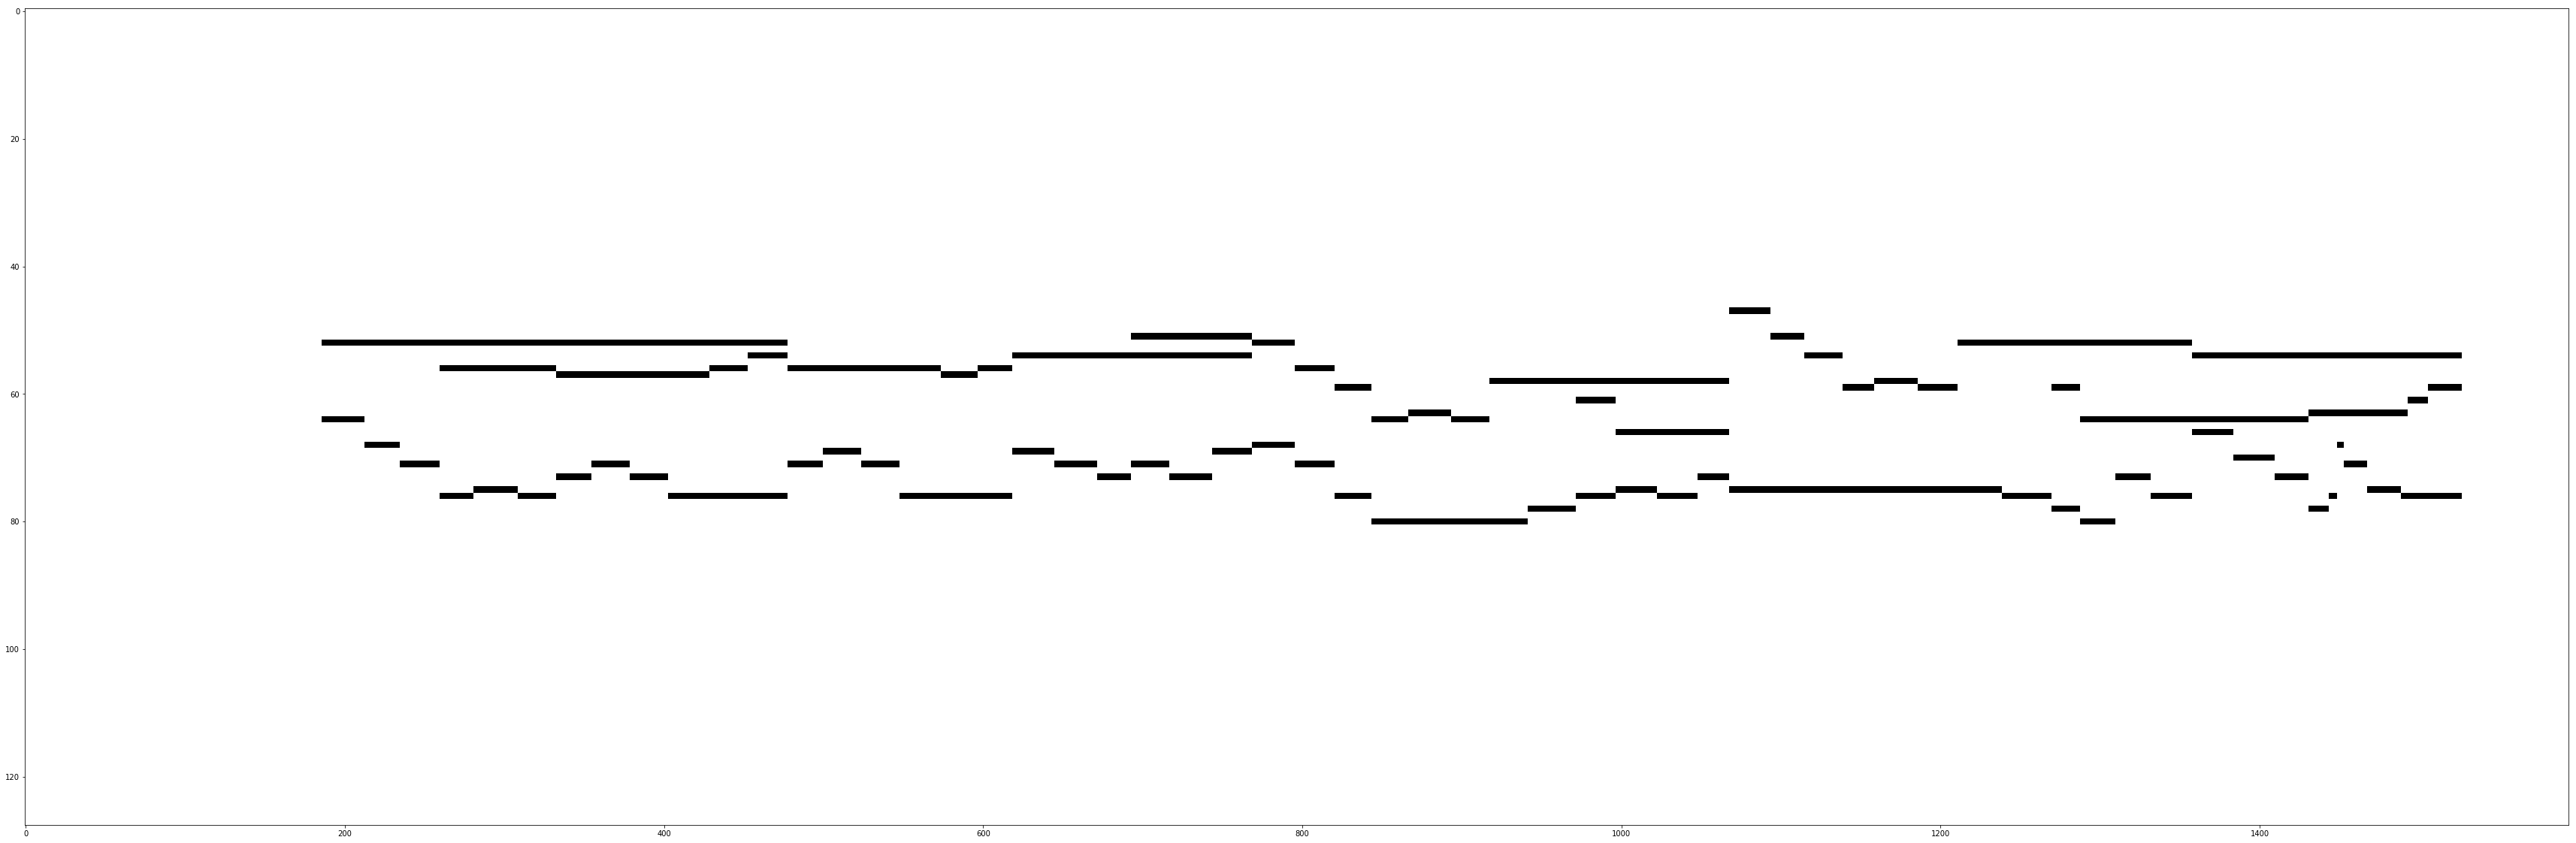

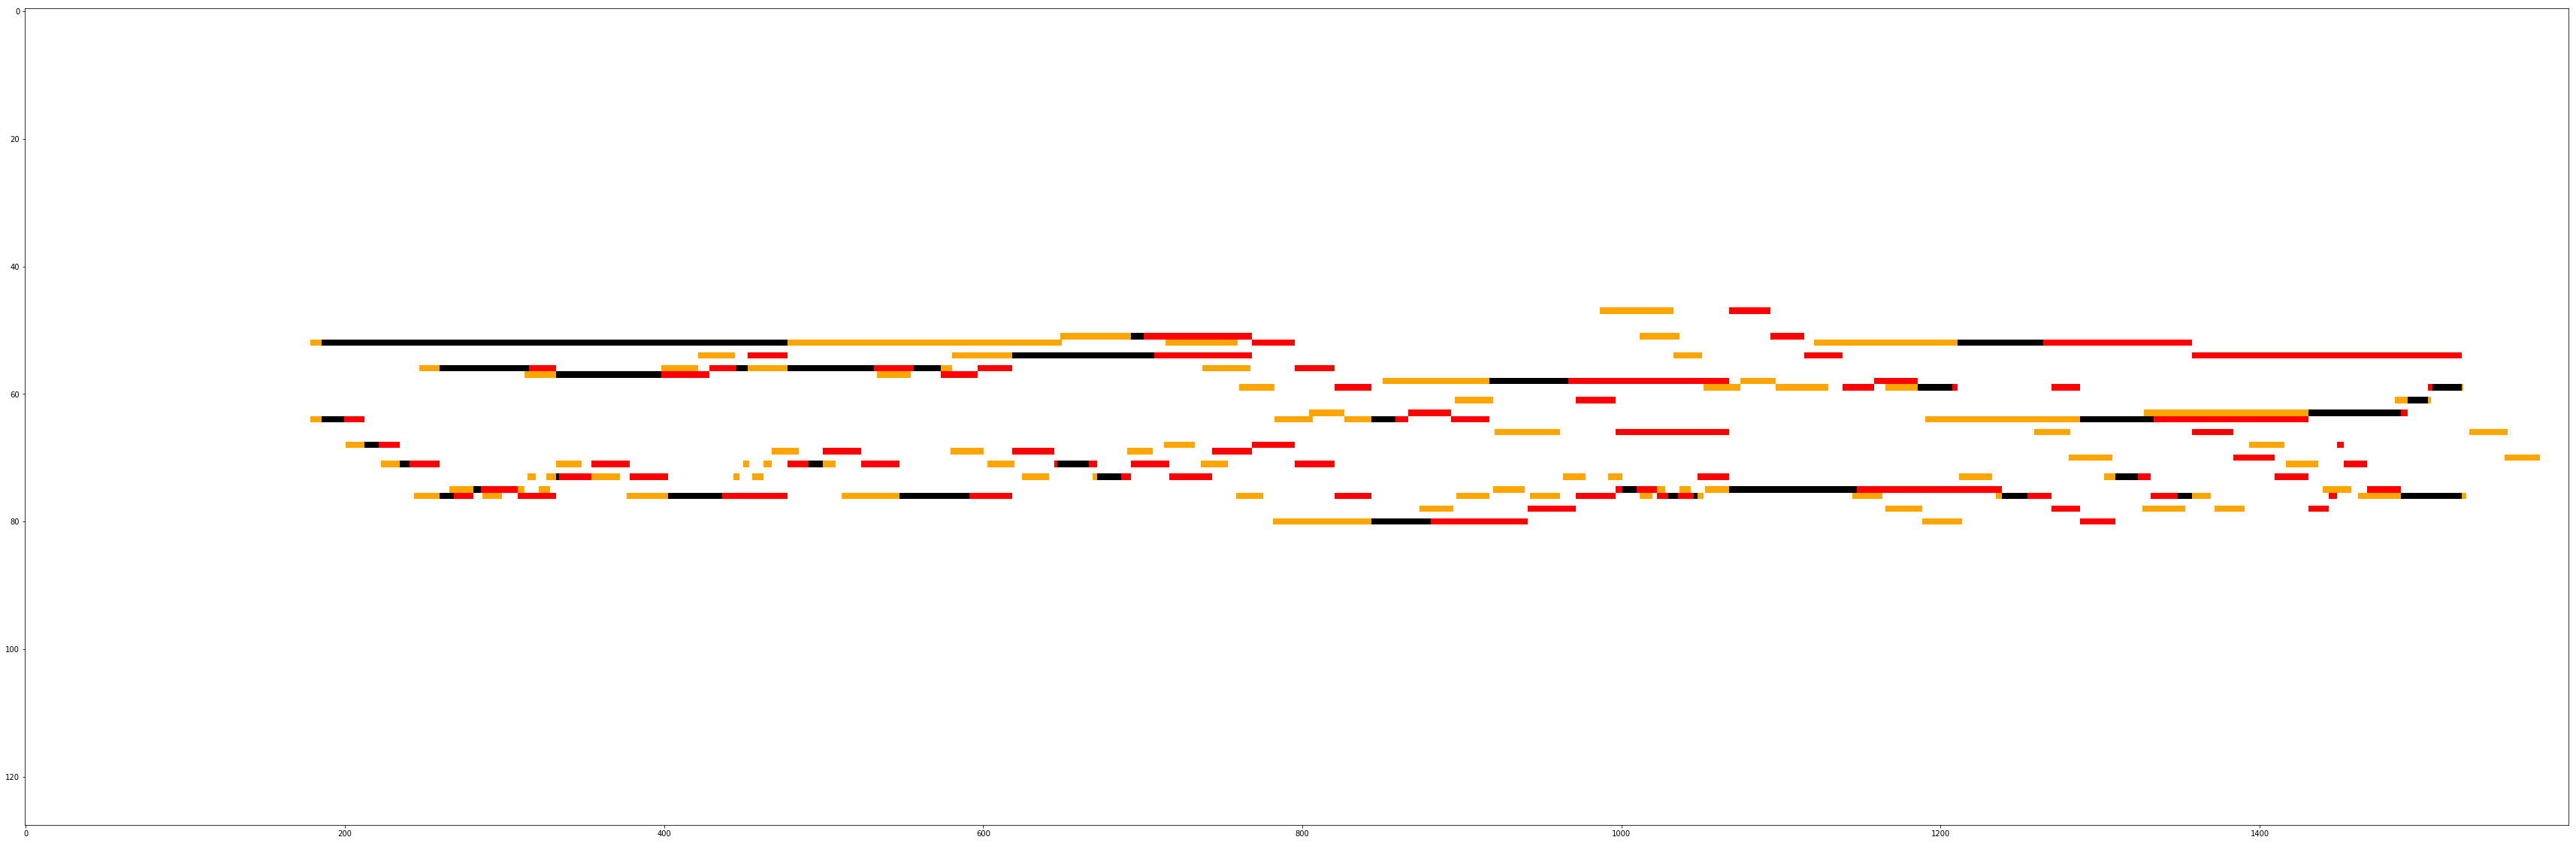

In [65]:
window_size=2048
stride=512
cutoff=int(50*(window_size/2048.))
record = './test/065_bwv854.wav'
synth = './test/bwv854_prelude_score.wav'

print('record', record)
print('synth', synth)
fs, data1 = wavfile.read(record)
left_pad = 1*fs
right_pad = 0*fs
data1 = data1[0:int(16.0*fs)]
data1 = np.concatenate((np.zeros((left_pad,2)),data1),axis=0)
frep1 = database.featurize(data1,fs,musiclib.feature,window_size,stride=stride,normalize=False)

fs, data2 = wavfile.read(synth)
data2 = data2[0:int(fs*20.30)]
data2 = np.concatenate((np.zeros((left_pad,2)),data2),axis=0)
frep2 = database.featurize(data2,fs,musiclib.feature,window_size,stride=stride,normalize=False)

# Align signals
start = time.time()
L,P = align(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32))
end = time.time()
print('Elapsed time: ' + str(end - start))

# Find optimal path
path,costs = traceback_loss(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32),L)
path1 = np.array([x[0] for x in path])
path2 = np.array([x[1] for x in path])

# Find corresponding onsets on the performance
notes_onsets_offsets_2 = musiclib.load_midi('./test/bwv854_prelude_score.midi')
for i, e in list(enumerate(notes_onsets_offsets_2)):
    notes_onsets_offsets_2[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_1 = []    
for note, onset, offset in notes_onsets_offsets_2:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    sig2_onset_index = np.argmax(path2>=int(onset))
    sig2_offset_index = np.argmax(path2>=int(offset))
    sig1_onset = path1[sig2_onset_index]
    sig1_offset = path1[sig2_offset_index]
    notes_onsets_offsets_1.append((note, sig1_onset, sig1_offset))
notes_onsets_offsets_1 = np.array(notes_onsets_offsets_1)

# Find the correct onsets from the maestro midi file wtc1p19.mid
notes_onsets_offsets_correct = musiclib.load_midi('./test/065_bwv854.mid')

for i, e in list(enumerate(notes_onsets_offsets_correct)):
    notes_onsets_offsets_correct[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_correct_temp = []

for note, onset, offset in notes_onsets_offsets_correct:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    notes_onsets_offsets_correct_temp.append((note, onset, offset))
notes_onsets_offsets_correct = np.array(notes_onsets_offsets_correct_temp)

notes_onsets_offsets_correct = notes_onsets_offsets_correct.astype(int)

x = np.zeros((data1[:,0].shape[0], 128), dtype=bool)
y = np.zeros((data1[:,0].shape[0], 128), dtype=bool)

# Discretize maestro 
for note, onset, offset in notes_onsets_offsets_correct:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > x.shape[0] or offset > x.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        else:
            x[i][int(note)] = True  

# Discretize aligned midi         
for note, onset, offset in notes_onsets_offsets_1:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > y.shape[0] or offset > y.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        y[i][int(note)] = True

# Error conditions :
# 1) Something is playing in maestro and nothing is playing in alignment
# 2) Something is playing in alignment and nothing is playing in maestro
# This can be efficiently calculated using xor.

z = np.logical_xor(x[::512], y[::512])
print("Alignment Error: ", np.sum(z)) # total number of errors
print("Errors per second: ", np.sum(z)/(44100/512.)) # total number of errors
print("Errors per frame: ", np.sum(z)/len(z)) # total number of errors
plotColorMap(x, y, (200, 20))

In [49]:
Audio(data1[:,0],rate=fs)

In [50]:
Audio(data2[:,0],rate=fs)

# Performace 66 aligns properly

record ./test/066_bwv854.wav
synth ./test/bwv854_prelude_score.wav


/Users/harshverma/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Elapsed time: 0.13125991821289062
length of midi file94.5597952166669
length of midi file159.9322916666662
onset : 666112 offset 750080
Alignment Error:  1412
Errors per second:  16.39328798185941
Errors per frame:  0.9638225255972697
white means no mistake
red means playing when not supposed to
orange means not playing when supposed to
black means playing when supposed to


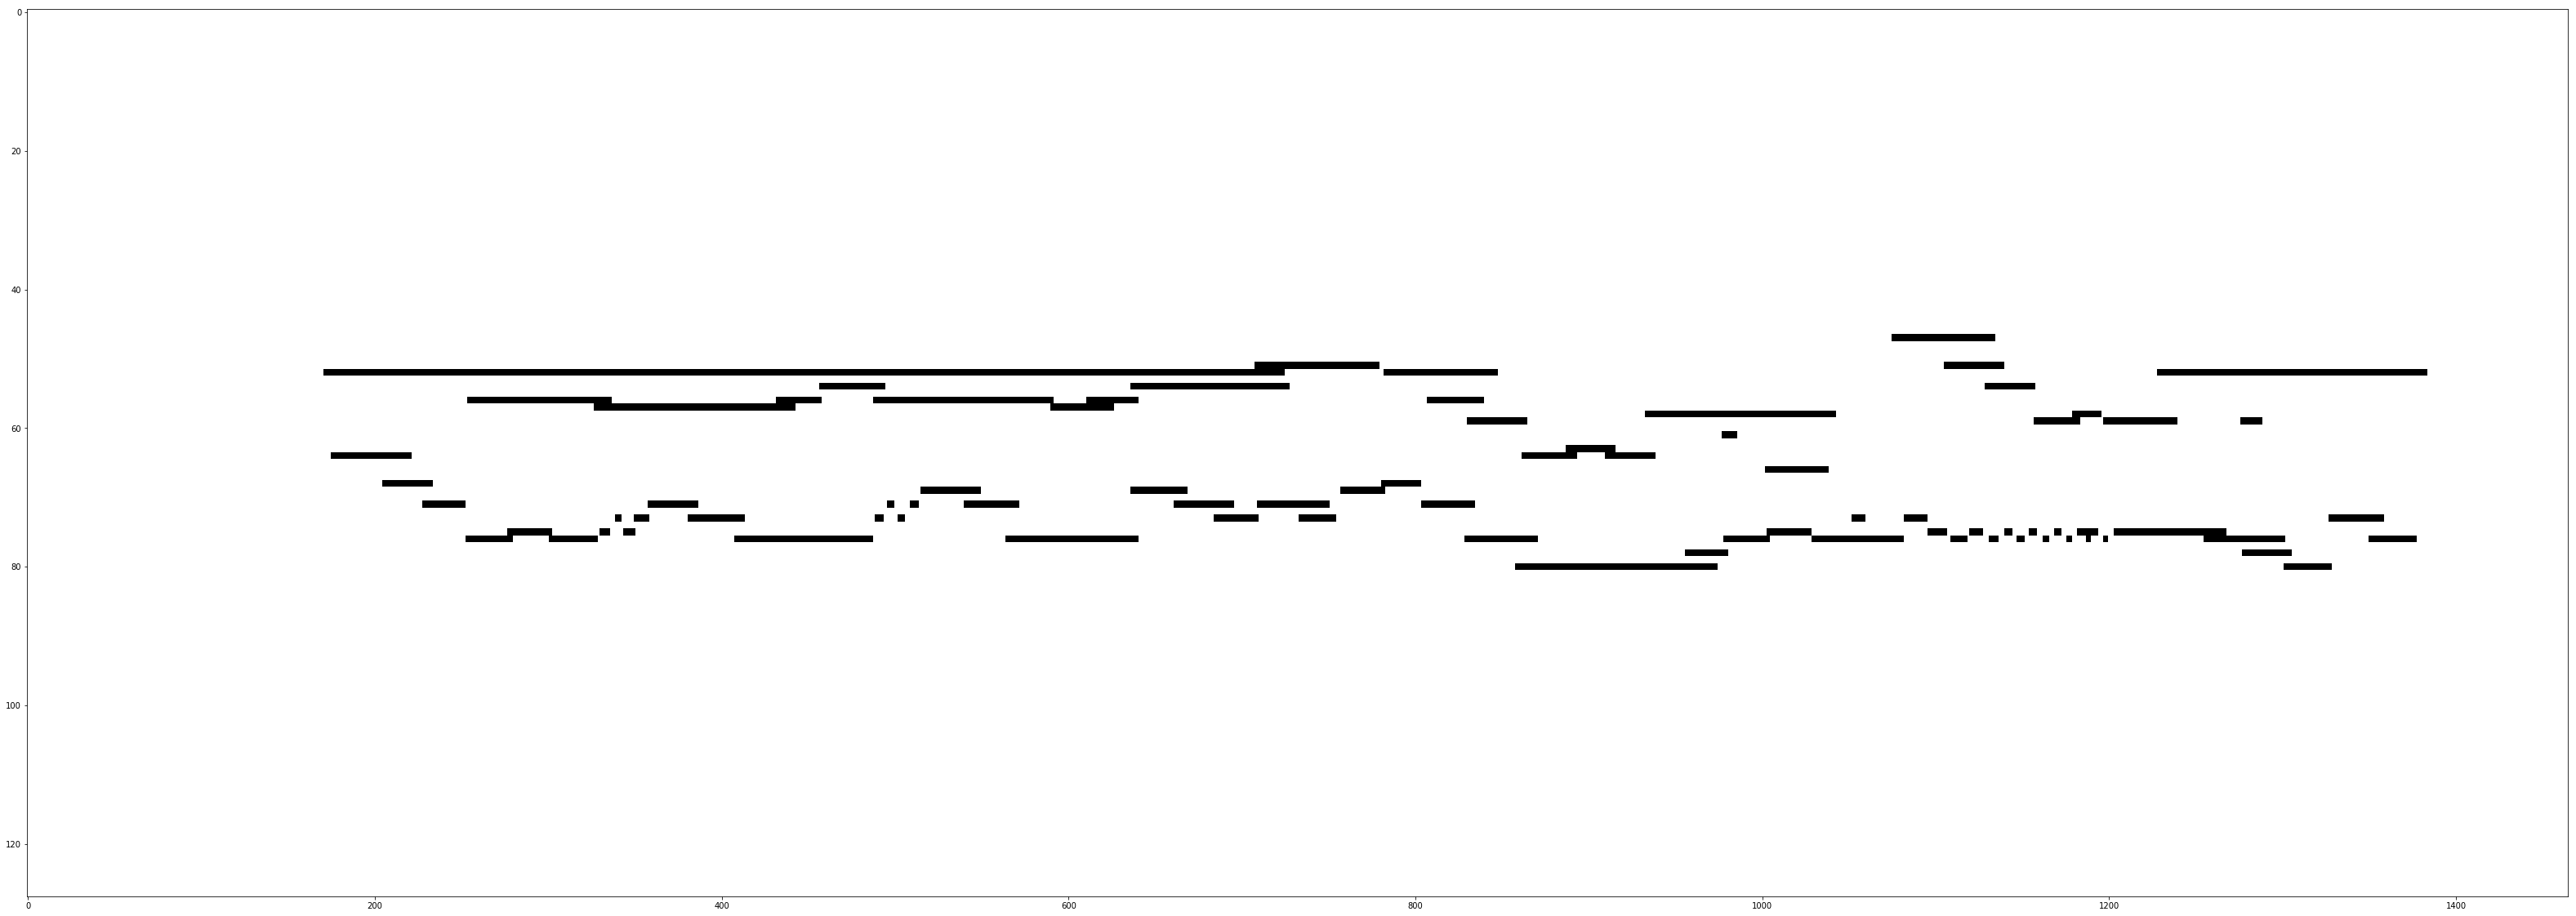

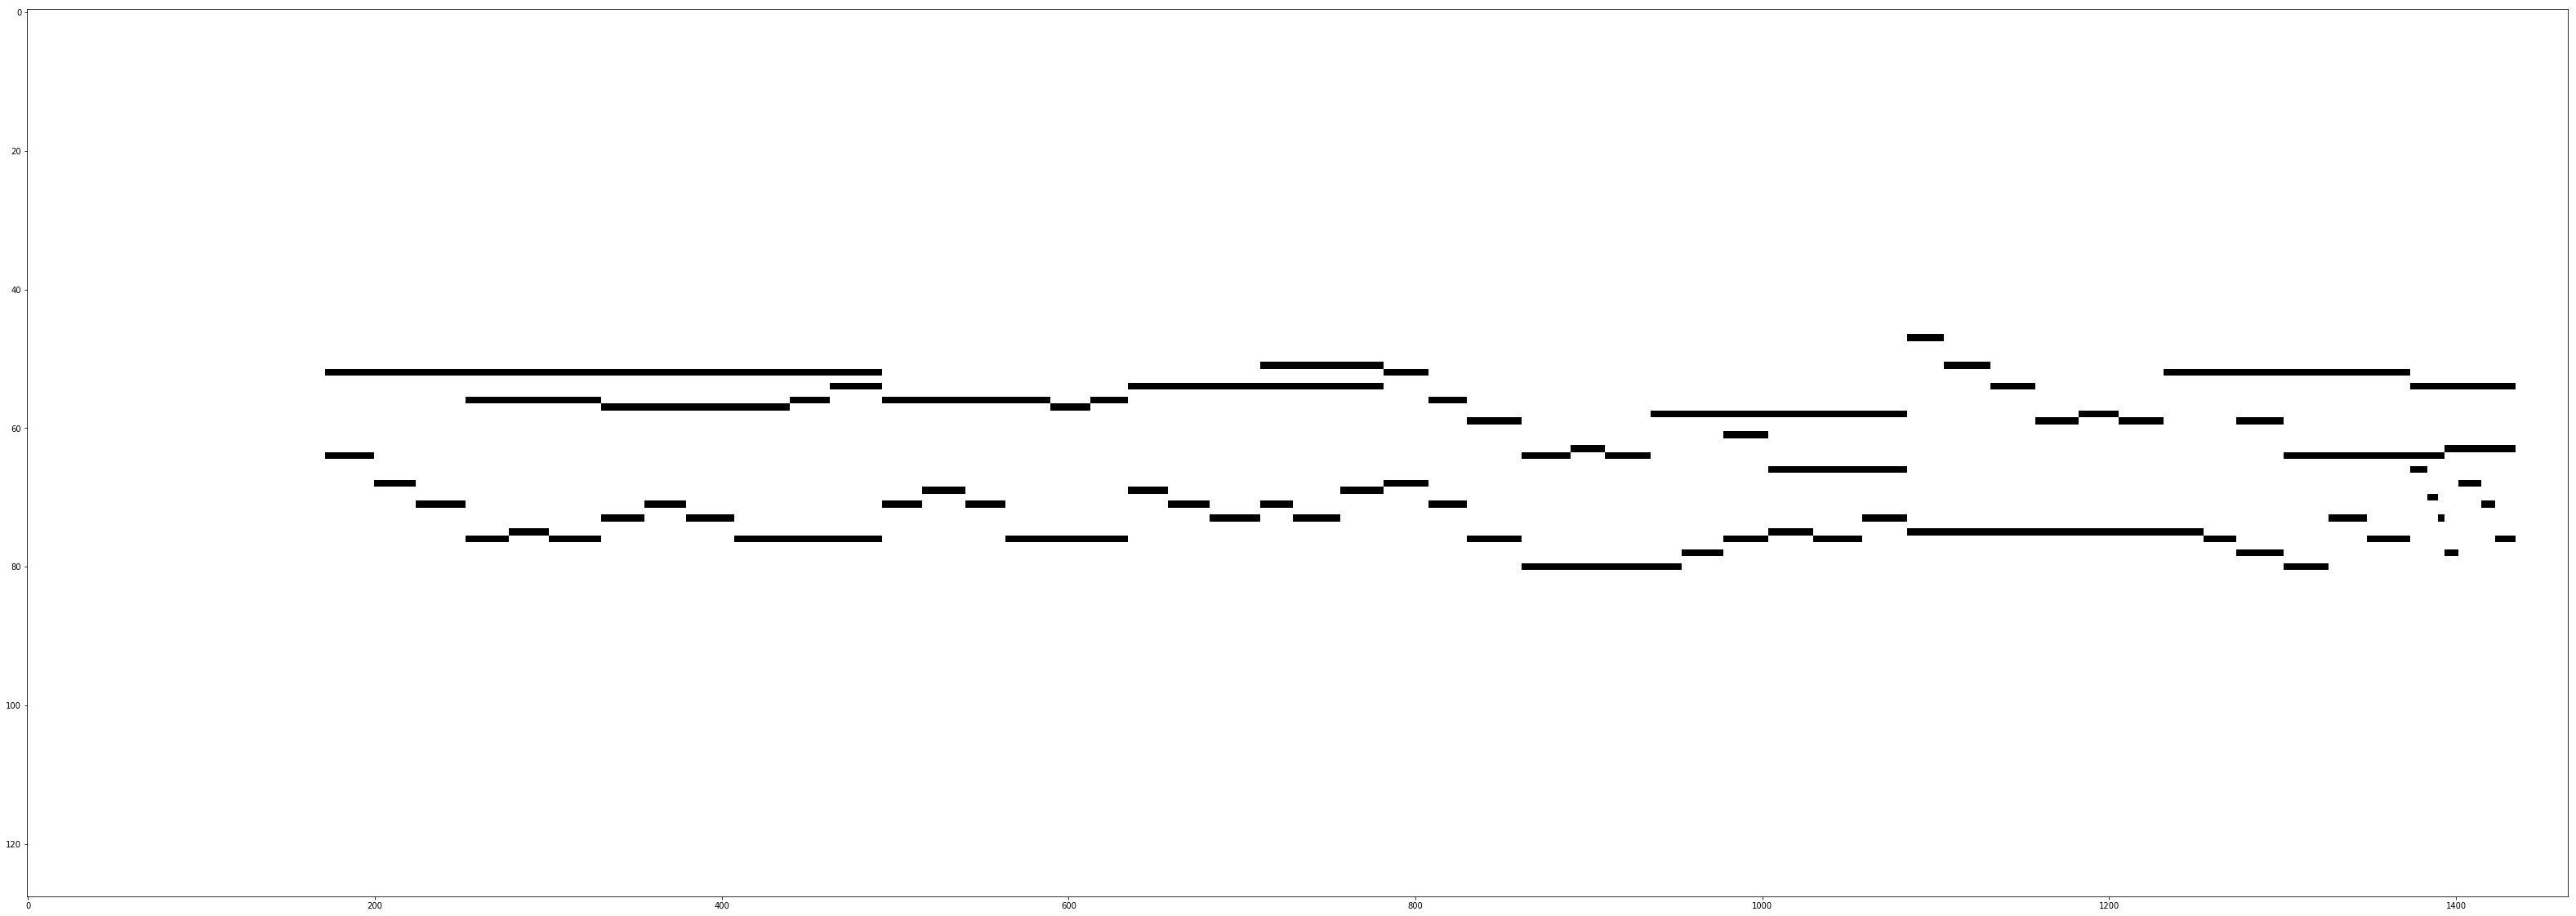

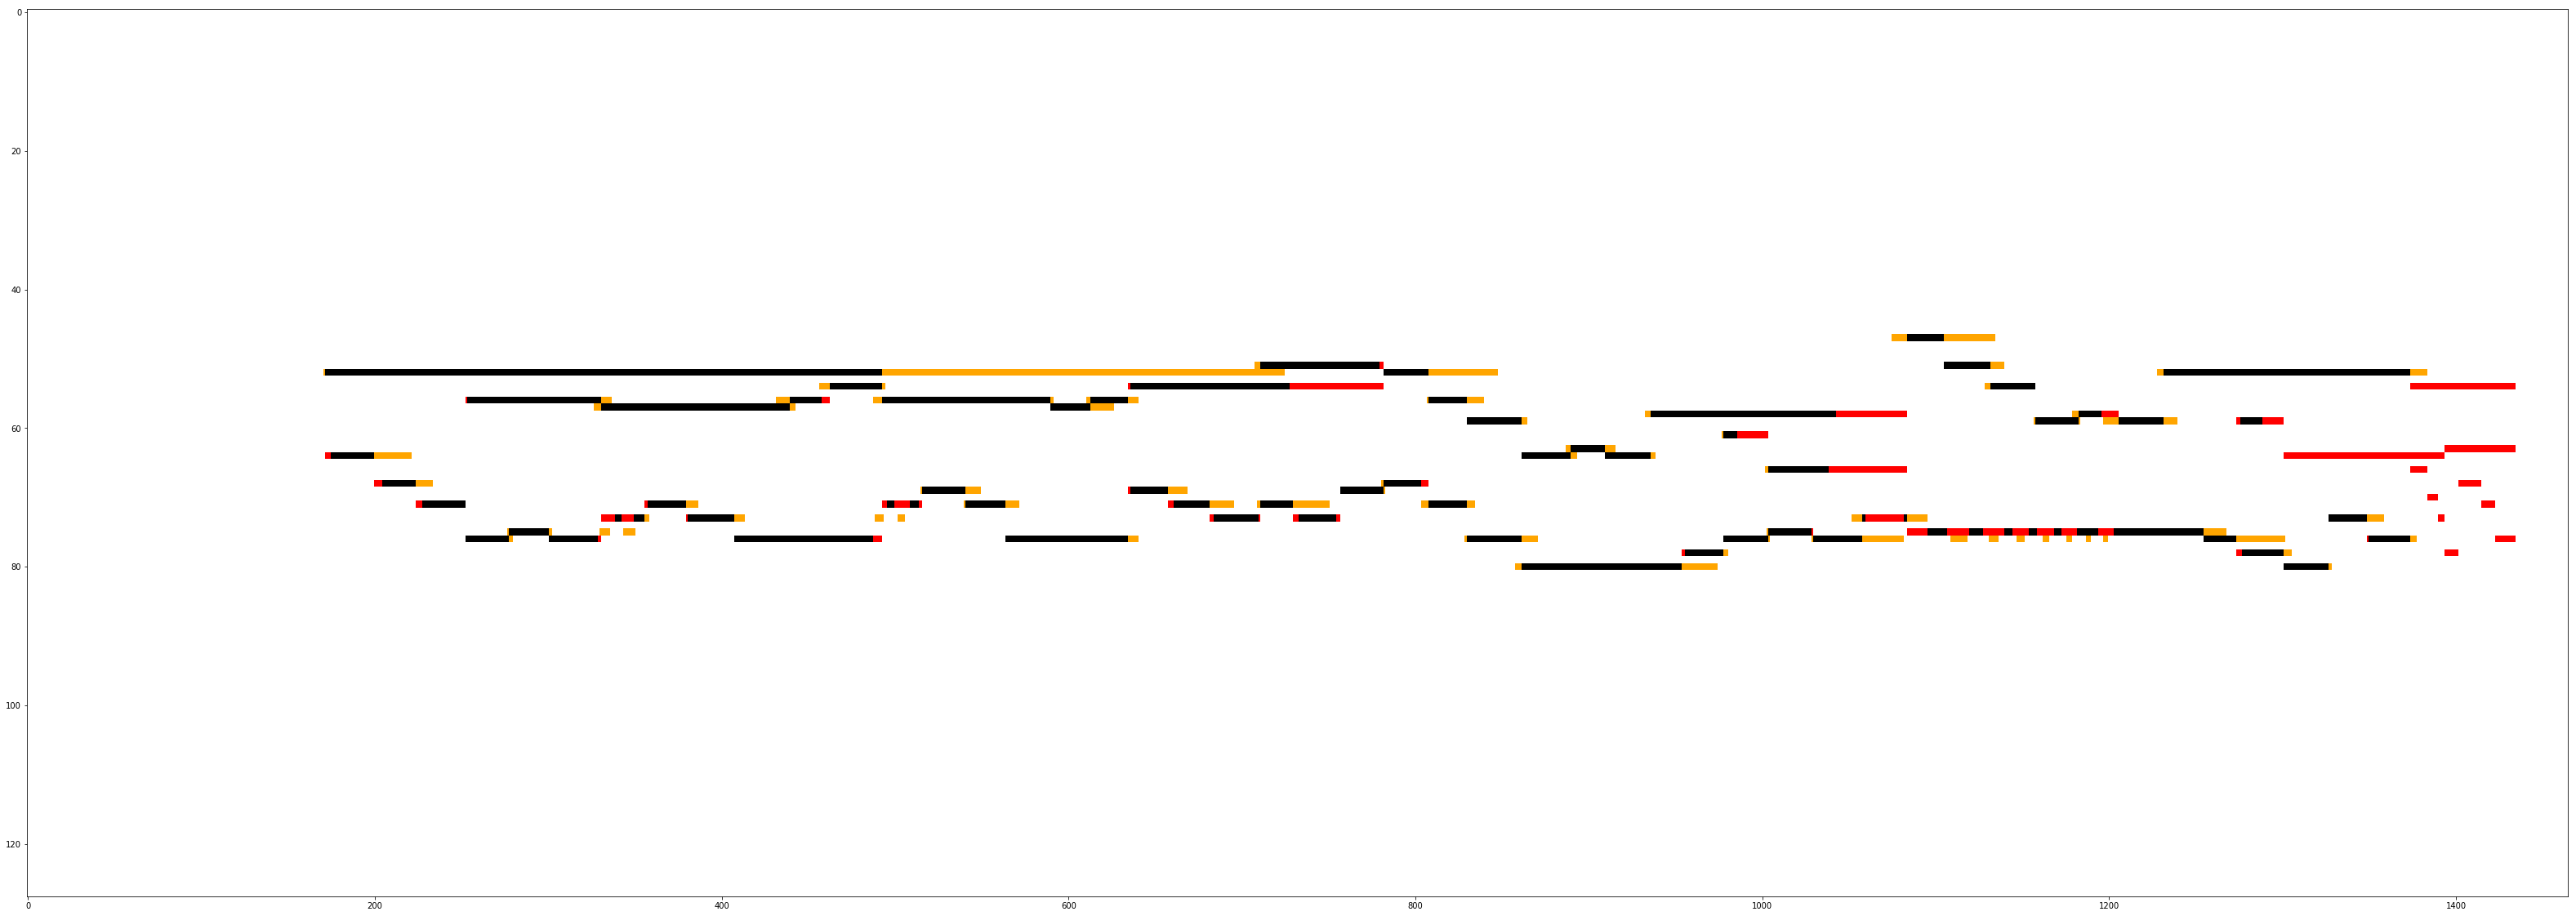

In [67]:
window_size=2048
stride=512
cutoff=int(50*(window_size/2048.))
record = './test/066_bwv854.wav'
synth = './test/bwv854_prelude_score.wav'

print('record', record)
print('synth', synth)
fs, data1 = wavfile.read(record)
left_pad = 1*fs
right_pad = 0*fs
data1 = data1[0:int(16.0*fs)]
data1 = np.concatenate((np.zeros((left_pad,2)),data1),axis=0)
frep1 = database.featurize(data1,fs,musiclib.feature,window_size,stride=stride,normalize=False)

fs, data2 = wavfile.read(synth)
data2 = data2[0:int(fs*20.30)]
data2 = np.concatenate((np.zeros((left_pad,2)),data2),axis=0)
frep2 = database.featurize(data2,fs,musiclib.feature,window_size,stride=stride,normalize=False)

# Align signals
start = time.time()
L,P = align(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32))
end = time.time()
print('Elapsed time: ' + str(end - start))

# Find optimal path
path,costs = traceback_loss(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32),L)
path1 = np.array([x[0] for x in path])
path2 = np.array([x[1] for x in path])

# Find corresponding onsets on the performance
notes_onsets_offsets_2 = musiclib.load_midi('./test/bwv854_prelude_score.midi')
for i, e in list(enumerate(notes_onsets_offsets_2)):
    notes_onsets_offsets_2[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_1 = []    
for note, onset, offset in notes_onsets_offsets_2:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    sig2_onset_index = np.argmax(path2>=int(onset))
    sig2_offset_index = np.argmax(path2>=int(offset))
    sig1_onset = path1[sig2_onset_index]
    sig1_offset = path1[sig2_offset_index]
    notes_onsets_offsets_1.append((note, sig1_onset, sig1_offset))
notes_onsets_offsets_1 = np.array(notes_onsets_offsets_1)

# Find the correct onsets from the maestro midi file wtc1p19.mid
notes_onsets_offsets_correct = musiclib.load_midi('./test/066_bwv854.mid')

for i, e in list(enumerate(notes_onsets_offsets_correct)):
    notes_onsets_offsets_correct[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_correct_temp = []

for note, onset, offset in notes_onsets_offsets_correct:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    notes_onsets_offsets_correct_temp.append((note, onset, offset))
notes_onsets_offsets_correct = np.array(notes_onsets_offsets_correct_temp)

notes_onsets_offsets_correct = notes_onsets_offsets_correct.astype(int)

x = np.zeros((data1[:,0].shape[0], 128), dtype=bool)
y = np.zeros((data1[:,0].shape[0], 128), dtype=bool)

# Discretize maestro 
for note, onset, offset in notes_onsets_offsets_correct:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > x.shape[0] or offset > x.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        else:
            x[i][int(note)] = True  

# Discretize aligned midi         
for note, onset, offset in notes_onsets_offsets_1:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > y.shape[0] or offset > y.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        y[i][int(note)] = True

# Error conditions :
# 1) Something is playing in maestro and nothing is playing in alignment
# 2) Something is playing in alignment and nothing is playing in maestro
# This can be efficiently calculated using xor.

z = np.logical_xor(x[::512], y[::512])
print("Alignment Error: ", np.sum(z)) # total number of errors
print("Errors per second: ", np.sum(z)/(44100/512.)) # total number of errors
print("Errors per frame: ", np.sum(z)/len(z)) # total number of errors
plotColorMap(x, y, (200, 20))

# 106_bwv863_prelude does not align properly

record ./test/106_bwv863.wav
synth ./test/bwv863_prelude_score.wav


/Users/harshverma/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Elapsed time: 0.15357494354248047
Alignment Error:  6434
Errors per second:  74.69859410430838
Errors per frame:  3.267648552564754
white means no mistake
red means playing when not supposed to
orange means not playing when supposed to
black means playing when supposed to


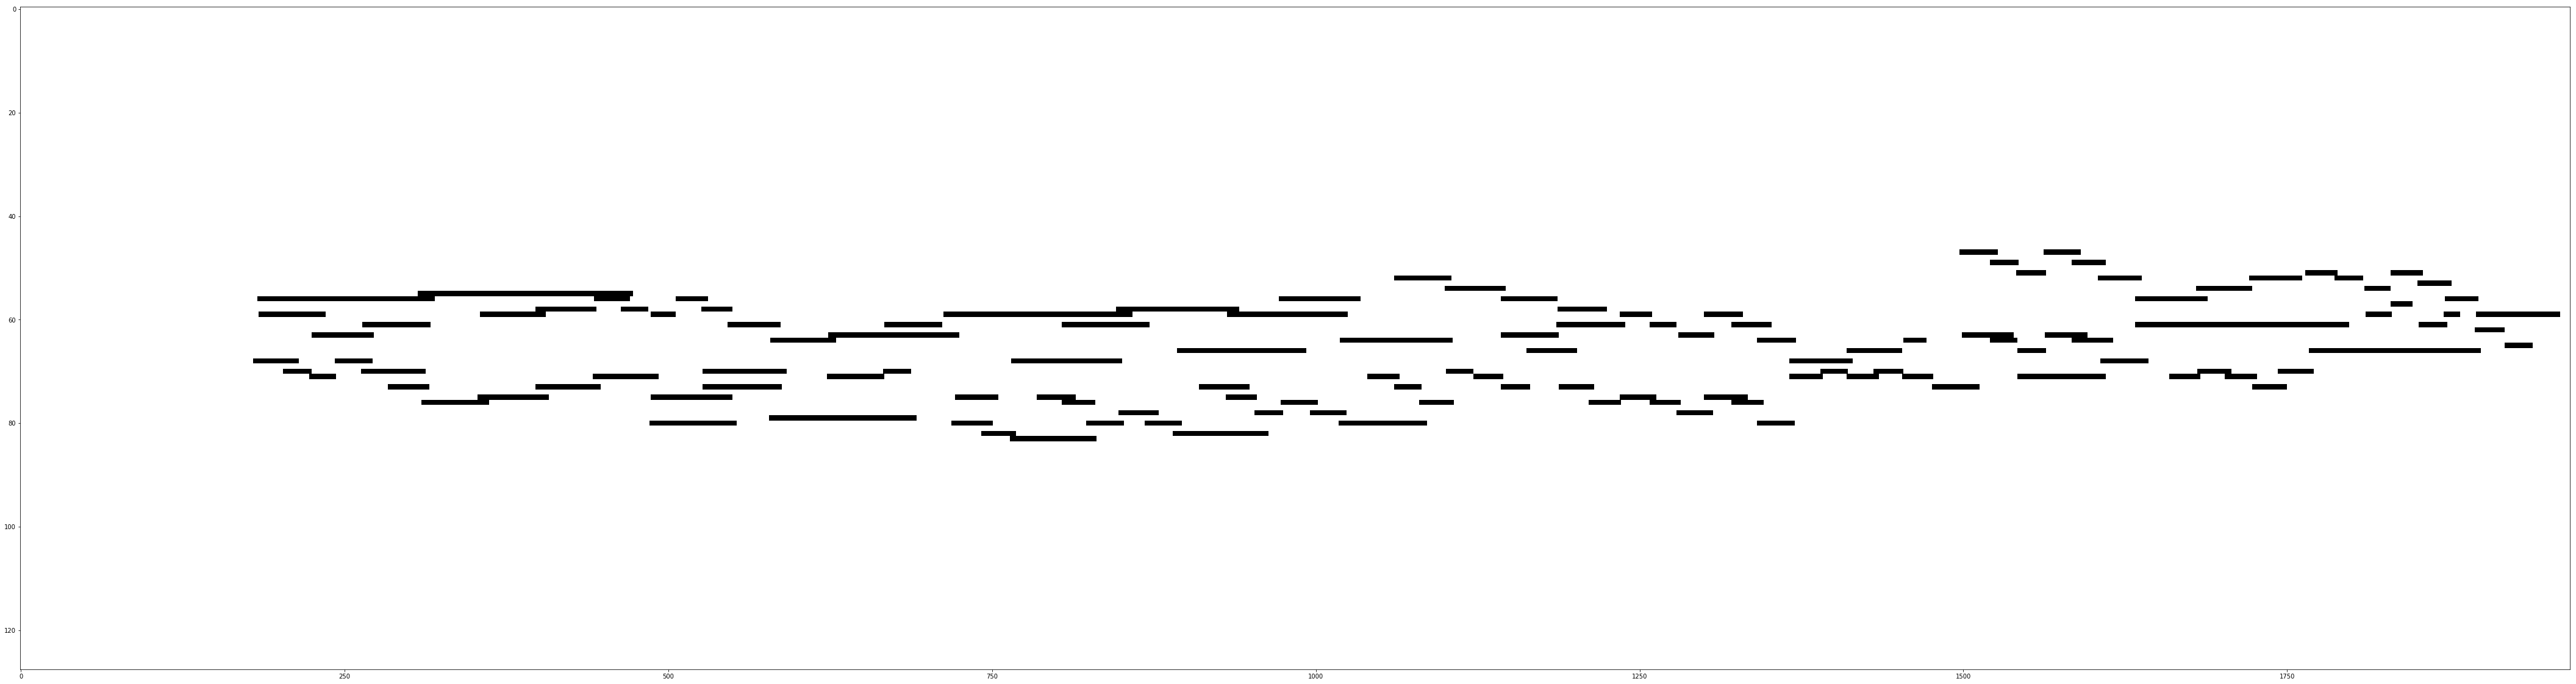

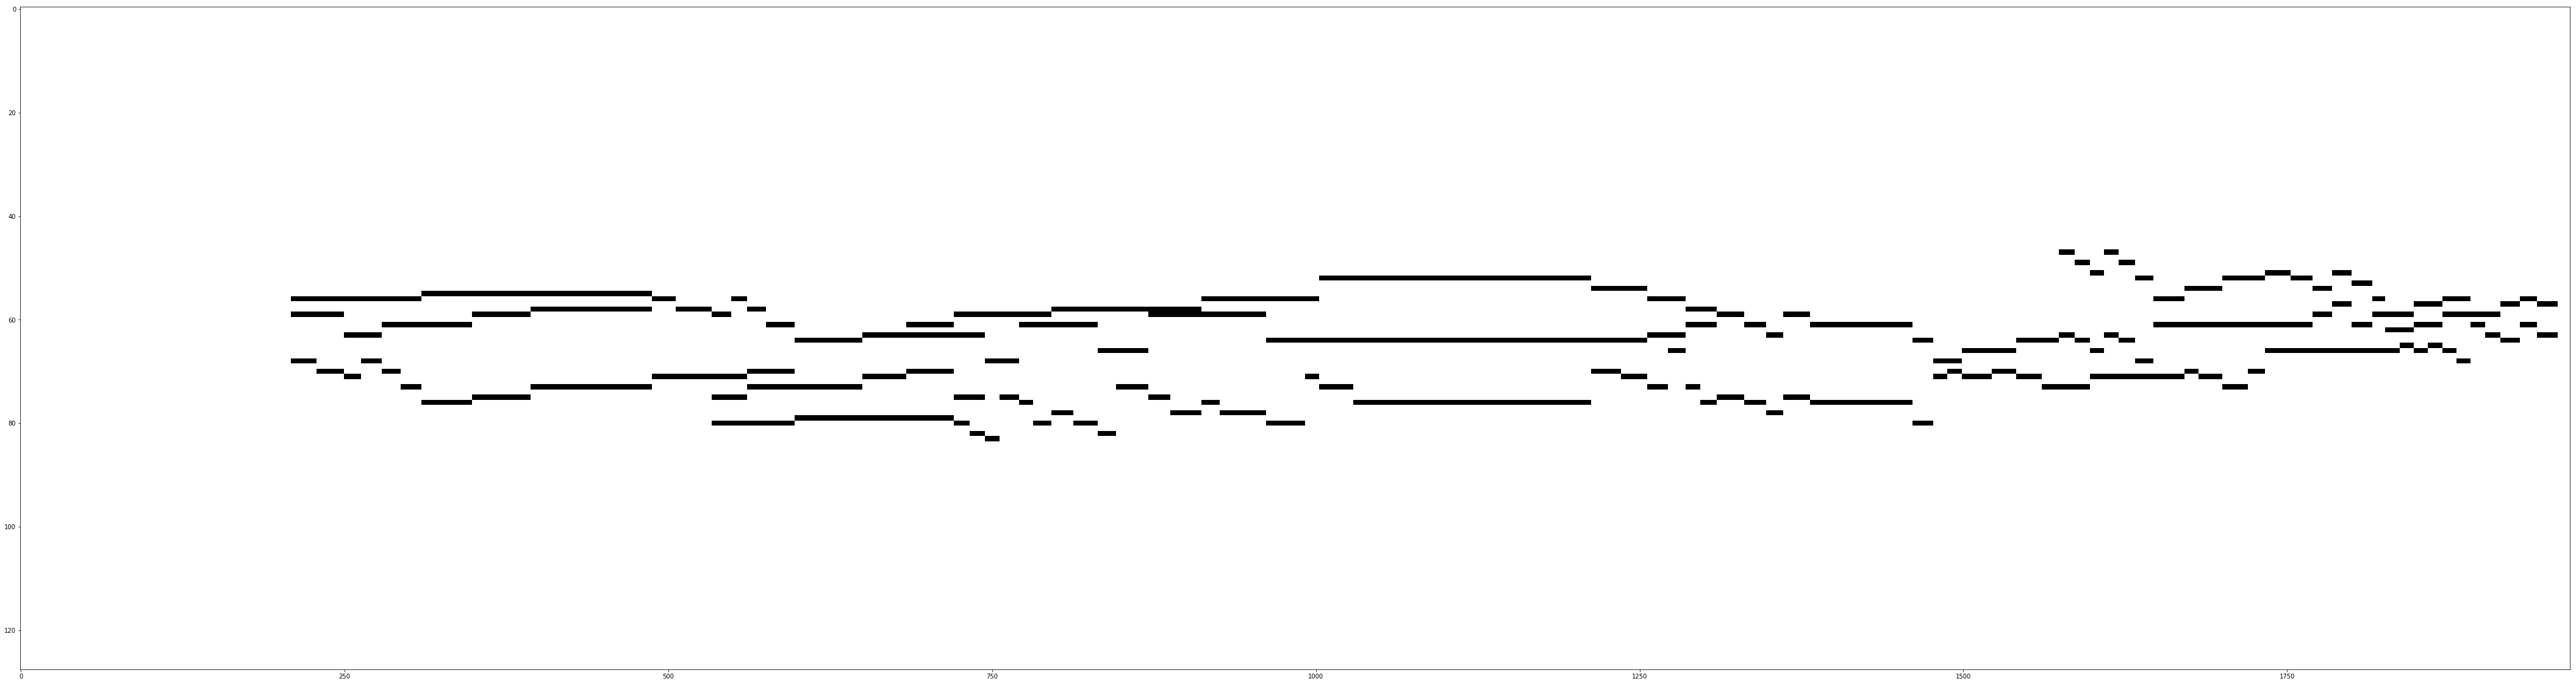

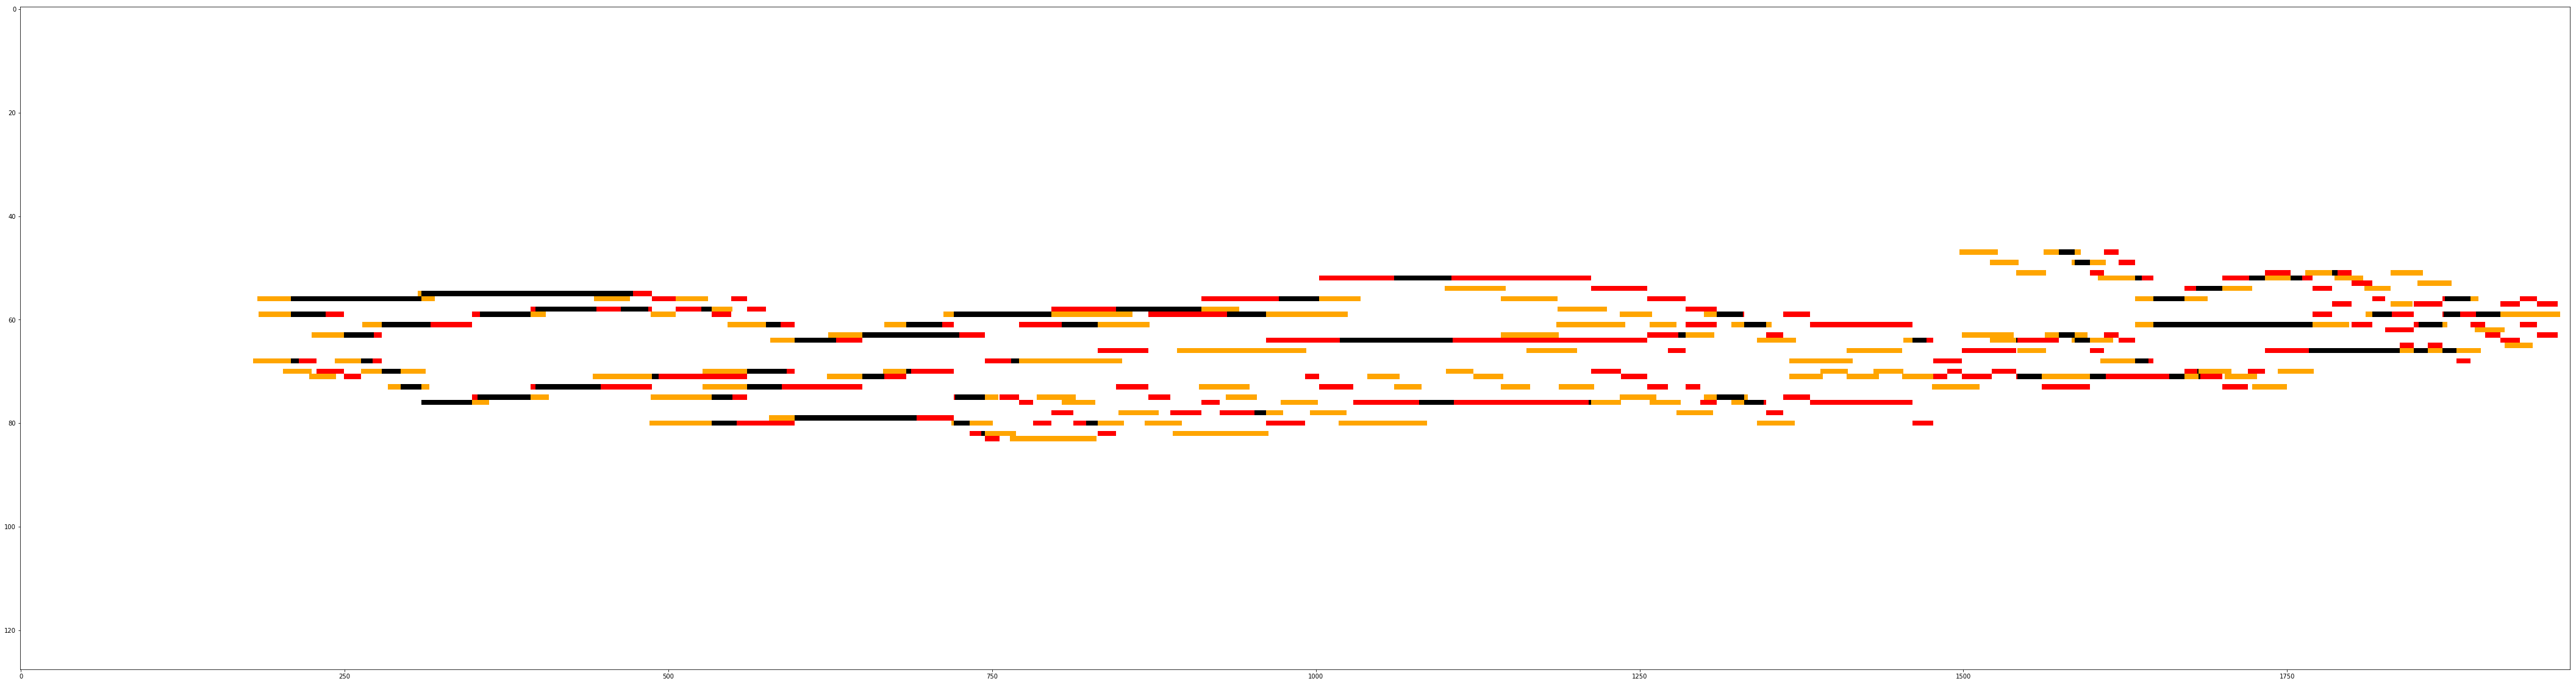

In [24]:
window_size=2048
stride=512
cutoff=int(50*(window_size/2048.))
record = './test/106_bwv863.wav'
synth = './test/bwv863_prelude_score.wav'

print('record', record)
print('synth', synth)
fs, data1 = wavfile.read(record)
left_pad = 1*fs
right_pad = 0*fs
data1 = data1[0:int(20.0*fs)]
data1 = np.concatenate((np.zeros((left_pad,2)),data1),axis=0)
frep1 = database.featurize(data1,fs,musiclib.feature,window_size,stride=stride,normalize=False)

fs, data2 = wavfile.read(synth)
data2 = data2[0:int(fs*11.60)]
data2 = np.concatenate((np.zeros((left_pad,2)),data2),axis=0)
frep2 = database.featurize(data2,fs,musiclib.feature,window_size,stride=stride,normalize=False)

# Align signals
start = time.time()
L,P = align(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32))
end = time.time()
print('Elapsed time: ' + str(end - start))

# Find optimal path
path,costs = traceback_loss(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32),L)
path1 = np.array([x[0] for x in path])
path2 = np.array([x[1] for x in path])

if path1[-1] >= path2[-1]:
    longer_piece_length = path1[-1]
else:
    longer_piece_length = path2[-1]

# Find corresponding onsets on the performance
notes_onsets_offsets_2 = musiclib.load_midi('./test/bwv863_prelude_score.midi')
for i, e in list(enumerate(notes_onsets_offsets_2)):
    notes_onsets_offsets_2[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_1 = []    
for note, onset, offset in notes_onsets_offsets_2:
    if (onset > longer_piece_length - right_pad/stride) or (offset > longer_piece_length - right_pad/stride):
        break
    sig2_onset_index = np.argmax(path2>=int(onset))
    sig2_offset_index = np.argmax(path2>=int(offset))
    sig1_onset = path1[sig2_onset_index]
    sig1_offset = path1[sig2_offset_index]
    notes_onsets_offsets_1.append((note, sig1_onset, sig1_offset))
notes_onsets_offsets_1 = np.array(notes_onsets_offsets_1)

# Find the correct onsets from the maestro midi file wtc1p19.mid
notes_onsets_offsets_correct = musiclib.load_midi('./test/106_bwv863.mid')

for i, e in list(enumerate(notes_onsets_offsets_correct)):
    notes_onsets_offsets_correct[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_correct_temp = []



for note, onset, offset in notes_onsets_offsets_correct:
    if (onset > longer_piece_length - right_pad/stride) or (offset > longer_piece_length - right_pad/stride):
        break
    notes_onsets_offsets_correct_temp.append((note, onset, offset))
notes_onsets_offsets_correct = np.array(notes_onsets_offsets_correct_temp)

notes_onsets_offsets_correct = notes_onsets_offsets_correct.astype(int)

x = np.zeros((data1[:,0].shape[0], 128), dtype=bool)
y = np.zeros((data1[:,0].shape[0], 128), dtype=bool)

# Discretize maestro 
for note, onset, offset in notes_onsets_offsets_correct:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > x.shape[0] or offset > x.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        else:
            x[i][int(note)] = True  

# Discretize aligned midi         
for note, onset, offset in notes_onsets_offsets_1:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > y.shape[0] or offset > y.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        y[i][int(note)] = True

# Error conditions :
# 1) Something is playing in maestro and nothing is playing in alignment
# 2) Something is playing in alignment and nothing is playing in maestro
# This can be efficiently calculated using xor.

z = np.logical_xor(x[::512], y[::512])
print("Alignment Error: ", np.sum(z)) # total number of errors
print("Errors per second: ", np.sum(z)/(44100/512.)) # total number of errors
print("Errors per frame: ", np.sum(z)/len(z)) # total number of errors
plotColorMap(x, y, (200, 20))